## InvestIQ - Multi agent system with Self reflection (Evaluation & Optimization Loop)

In [1]:
"""
InvestIQ - Multi-Agent AI Solution with Self-Reflection
Complete implementation with detailed line-by-line comments
"""

# ============================================================================
# IMPORTS SECTION
# ============================================================================

# Load environment variables from .env file (for API keys)
from dotenv import load_dotenv

# Type hints for better code documentation and IDE support
from typing import Dict, Any, List, Optional, Literal

# Pydantic for data validation and settings management
from pydantic import BaseModel, Field

# LangChain's unified interface for different LLM providers
from langchain.chat_models import init_chat_model

# LangChain core message types for conversation flow
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# LangGraph prebuilt agent creator for ReAct (Reasoning + Acting) pattern
from langgraph.prebuilt import create_react_agent

# LangGraph state management for building complex workflows
from langgraph.graph import StateGraph, START, END

# LangChain tools decorator for creating custom tools
from langchain.tools import tool

# Yahoo Finance library for fetching stock market data
import yfinance as yf

# JSON handling for parsing and formatting data
import json

# Regular expressions for pattern matching and text extraction
import re

# Operating system interface for file operations and environment variables
import os

# DateTime for timestamp operations
from datetime import datetime

# Load all environment variables from .env file into os.environ
load_dotenv()

# ============================================================================
# TOOL FUNCTIONS - These are the actual functions agents can call
# ============================================================================

def get_stock_data(ticker: str) -> Dict[str, Any]:
    """
    Fetches current stock market data for a given ticker symbol.
    This is a TOOL that agents can invoke to get real-time stock information.
    
    Args:
        ticker (str): The stock ticker symbol (e.g., "AAPL", "MSFT").
    
    Returns:
        Dict[str, Any]: A dictionary containing stock information,
        or an error message if the ticker is invalid.
    """
    try:
        # Validate input - check if ticker exists and is a string
        if not ticker or not isinstance(ticker, str):
            # Return error dict if input is invalid
            return {"error": "Invalid ticker symbol provided"}
        
        # Clean up the ticker: remove whitespace and convert to uppercase
        ticker = ticker.strip().upper()
        
        # Create a yfinance Ticker object for the given symbol
        stock = yf.Ticker(ticker)
        
        # Fetch all available information about the stock
        info = stock.info

        # Check if we got valid data back (info dict should have multiple keys)
        if not info or len(info) < 5:
            # Return error if ticker doesn't exist or no data available
            return {"error": f"Could not retrieve data for ticker: {ticker}. It might be invalid."}

        # Extract and organize the most relevant stock data into a clean dictionary
        data = {
            "ticker": ticker,  # The stock symbol
            "shortName": info.get("shortName", "N/A"),  # Company name
            # Current price, with fallback to regularMarketPrice if currentPrice unavailable
            "currentPrice": info.get("currentPrice", info.get("regularMarketPrice", "N/A")),
            "previousClose": info.get("previousClose", "N/A"),  # Yesterday's closing price
            "open": info.get("open", "N/A"),  # Today's opening price
            "dayHigh": info.get("dayHigh", "N/A"),  # Highest price today
            "dayLow": info.get("dayLow", "N/A"),  # Lowest price today
            "volume": info.get("volume", "N/A"),  # Number of shares traded
            "marketCap": info.get("marketCap", "N/A"),  # Total company value
            "currency": info.get("currency", "N/A"),  # Currency of the stock
            "exchange": info.get("exchange", "N/A"),  # Stock exchange (NYSE, NASDAQ, etc.)
            "sector": info.get("sector", "N/A"),  # Business sector
            "industry": info.get("industry", "N/A"),  # Specific industry
            "longBusinessSummary": info.get("longBusinessSummary", "N/A")  # Company description
        }
        # Return the organized data dictionary
        return data
        print (data)
    except Exception as e:
        # Catch any unexpected errors and return error message with details
        return {"error": f"An unexpected error occurred while fetching data for {ticker}: {str(e)}"}

In [2]:
#Testing get_stock_data function 
get_stock_data("MSFT")

{'ticker': 'MSFT',
 'shortName': 'Microsoft Corporation',
 'currentPrice': 513.58,
 'previousClose': 511.61,
 'open': 509.04,
 'dayHigh': 515.48,
 'dayLow': 507.33,
 'volume': 19205931,
 'marketCap': 3817525739520,
 'currency': 'USD',
 'exchange': 'NMS',
 'sector': 'Technology',
 'industry': 'Software - Infrastructure',
 'longBusinessSummary': "Microsoft Corporation develops and supports software, services, devices, and solutions worldwide. The company's Productivity and Business Processes segment offers Microsoft 365 Commercial, Enterprise Mobility + Security, Windows Commercial, Power BI, Exchange, SharePoint, Microsoft Teams, Security and Compliance, and Copilot; Microsoft 365 Commercial products, such as Windows Commercial on-premises and Office licensed services; Microsoft 365 Consumer products and cloud services, such as Microsoft 365 Consumer subscriptions, Office licensed on-premises, and other consumer services; LinkedIn; Dynamics products and cloud services, such as Dynamics 

In [3]:
def get_financial_data_fixed(ticker: str) -> str:
    """
    Fixed version that handles Timestamp objects in DataFrame columns.
    """
    print(f"\n{'='*60}")
    print(f"Testing financial data fetch for: {ticker}")
    print('='*60)
    
    try:
        # Validate input
        if not ticker or not isinstance(ticker, str):
            return json.dumps({"error": "Invalid ticker symbol provided"})
        
        # Clean ticker
        ticker = ticker.strip().upper()
        print(f"✓ Ticker validated: {ticker}")
        
        # Create Ticker object
        stock = yf.Ticker(ticker)
        
        # Verify ticker exists
        info = stock.info
        if not info or len(info) < 5:
            return json.dumps({"error": f"Could not retrieve data for ticker: {ticker}"})
        
        print(f"✓ Stock info retrieved: {info.get('shortName', 'N/A')}")

        # Helper function to safely convert DataFrame to dict
        def df_to_dict_safe(df):
            """Convert DataFrame to dict, handling Timestamp columns."""
            if df is None:
                print("  ⚠ DataFrame is None")
                return {}
            
            if df.empty:
                print("  ⚠ DataFrame is empty")
                return {}
            
            try:
                print(f"  📊 DataFrame shape: {df.shape}")
                print(f"  📊 Column types: {type(df.columns[0]) if len(df.columns) > 0 else 'No columns'}")
                
                # Create a copy to avoid modifying original
                df_copy = df.copy()
                
                # Convert column names to strings (handles Timestamp objects)
                df_copy.columns = df_copy.columns.astype(str)
                print(f"  ✓ Columns converted to strings")
                
                # Convert index to strings as well
                df_copy.index = df_copy.index.astype(str)
                print(f"  ✓ Index converted to strings")
                
                # Now convert to dict
                result = df_copy.to_dict()
                print(f"  ✓ Converted to dict with {len(result)} entries")
                
                return result
            except Exception as e:
                print(f"  ✗ Conversion error: {e}")
                return {}

        # Fetch income statement
        print("\n1. Fetching Income Statement...")
        try:
            if hasattr(stock, 'income_stmt') and stock.income_stmt is not None:
                print(f"   Available: Yes")
                income_stmt = df_to_dict_safe(stock.income_stmt)
            else:
                print(f"   Available: No")
                income_stmt = {}
        except Exception as e:
            print(f"   ✗ Error: {e}")
            income_stmt = {}
        
        # Fetch cash flow
        print("\n2. Fetching Cash Flow...")
        try:
            if hasattr(stock, 'cash_flow') and stock.cash_flow is not None:
                print(f"   Available: Yes")
                cash_flow = df_to_dict_safe(stock.cash_flow)
            else:
                print(f"   Available: No")
                cash_flow = {}
        except Exception as e:
            print(f"   ✗ Error: {e}")
            cash_flow = {}
        
        # Fetch balance sheet
        print("\n3. Fetching Balance Sheet...")
        try:
            if hasattr(stock, 'balance_sheet') and stock.balance_sheet is not None:
                print(f"   Available: Yes")
                balance_sheet = df_to_dict_safe(stock.balance_sheet)
            else:
                print(f"   Available: No")
                balance_sheet = {}
        except Exception as e:
            print(f"   ✗ Error: {e}")
            balance_sheet = {}
        
        # Fetch historical data
        print("\n4. Fetching Historical Data (1 month)...")
        try:
            if hasattr(stock, 'history'):
                hist = stock.history(period='1mo')
                if hist is not None and not hist.empty:
                    print(f"   Available: Yes")
                    hist_data = df_to_dict_safe(hist)
                else:
                    print(f"   Available: No data")
                    hist_data = {}
            else:
                print(f"   Available: No")
                hist_data = {}
        except Exception as e:
            print(f"   ✗ Error: {e}")
            hist_data = {}

        # Format the data
        print("\n5. Formatting output...")
        data = f"""
Financial Data for {ticker}:

Income Statement (latest quarters):
{json.dumps(income_stmt, indent=2, default=str)}

Cash Flow (latest quarters):
{json.dumps(cash_flow, indent=2, default=str)}

Balance Sheet (latest quarters):
{json.dumps(balance_sheet, indent=2, default=str)}

Historical Data (1 month):
{json.dumps(hist_data, indent=2, default=str)}
        """
        
        print("✓ Data formatted successfully")
        return data
        
    except Exception as e:
        error_msg = f"An unexpected error occurred: {str(e)}"
        print(f"\n✗ {error_msg}")
        return json.dumps({"error": error_msg})


def test_multiple_tickers():
    """Test with multiple tickers."""
    test_tickers = ["AAPL", "MSFT", "GOOGL", "TSLA"]
    
    print("\n" + "="*60)
    print("TESTING MULTIPLE TICKERS")
    print("="*60)
    
    results = {}
    
    for ticker in test_tickers:
        try:
            result = get_financial_data_fixed(ticker)
            
            # Check if it's an error
            if result.startswith('{"error"'):
                results[ticker] = " FAILED"
                print(f"\n{ticker}:  FAILED")
                print(result)
            else:
                results[ticker] = " SUCCESS"
                print(f"\n{ticker}:  SUCCESS")
                print(f"Data length: {len(result)} characters")
                # Show first 200 characters
                print(f"Preview: {result[:200]}...")
        except Exception as e:
            results[ticker] = " CRASHED"
            print(f"\n{ticker}:  CRASHED - {e}")
    
    # Summary
    print("\n" + "="*60)
    print("TEST SUMMARY")
    print("="*60)
    for ticker, status in results.items():
        print(f"{ticker}: {status}")
    
    success_count = sum(1 for s in results.values() if "SUCCESS" in s)
    print(f"\nTotal: {success_count}/{len(test_tickers)} successful")


if __name__ == "__main__":
    print("\n" + "="*80)
    print("FINANCIAL DATA TIMESTAMP FIX - VERIFICATION TEST")
    print("="*80)
    
    # Test single ticker (the one that was failing)
    print("\n Testing MSFT (the ticker that caused the original error)...")
    result = get_financial_data_fixed("MSFT")
    
    if '{"error"' in result:
        print("\n TEST FAILED!")
        print(result)
    else:
        print("\n TEST PASSED!")
        print(f"Successfully retrieved {len(result)} characters of financial data")
        print("\nFirst 500 characters:")
        print(result[:500])
    
    # Test multiple tickers
    print("\n" + "="*80)
    test_multiple_tickers()
    
    print("\n" + "="*80)
    print("TESTING COMPLETE")
    print("="*80)
    print("\n If all tests passed, the fix is working correctly!")
    print("You can now use get_financial_data() without Timestamp errors.")


FINANCIAL DATA TIMESTAMP FIX - VERIFICATION TEST

 Testing MSFT (the ticker that caused the original error)...

Testing financial data fetch for: MSFT
✓ Ticker validated: MSFT
✓ Stock info retrieved: Microsoft Corporation

1. Fetching Income Statement...
   Available: Yes
  📊 DataFrame shape: (47, 4)
  📊 Column types: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  ✓ Columns converted to strings
  ✓ Index converted to strings
  ✓ Converted to dict with 4 entries

2. Fetching Cash Flow...
   Available: Yes
  📊 DataFrame shape: (59, 5)
  📊 Column types: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  ✓ Columns converted to strings
  ✓ Index converted to strings
  ✓ Converted to dict with 5 entries

3. Fetching Balance Sheet...
   Available: Yes
  📊 DataFrame shape: (78, 5)
  📊 Column types: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  ✓ Columns converted to strings
  ✓ Index converted to strings
  ✓ Converted to dict with 5 entries

4. Fetching Historical Data (1 month

In [4]:
#Testing get_financial_data_fixed function 
get_financial_data_fixed("MSFT")


Testing financial data fetch for: MSFT
✓ Ticker validated: MSFT
✓ Stock info retrieved: Microsoft Corporation

1. Fetching Income Statement...
   Available: Yes
  📊 DataFrame shape: (47, 4)
  📊 Column types: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  ✓ Columns converted to strings
  ✓ Index converted to strings
  ✓ Converted to dict with 4 entries

2. Fetching Cash Flow...
   Available: Yes
  📊 DataFrame shape: (59, 5)
  📊 Column types: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  ✓ Columns converted to strings
  ✓ Index converted to strings
  ✓ Converted to dict with 5 entries

3. Fetching Balance Sheet...
   Available: Yes
  📊 DataFrame shape: (78, 5)
  📊 Column types: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  ✓ Columns converted to strings
  ✓ Index converted to strings
  ✓ Converted to dict with 5 entries

4. Fetching Historical Data (1 month)...
   Available: Yes
  📊 DataFrame shape: (22, 7)
  📊 Column types: <class 'str'>
  ✓ Columns converted to str

'\nFinancial Data for MSFT:\n\nIncome Statement (latest quarters):\n{\n  "2025-06-30": {\n    "Tax Effect Of Unusual Items": -77088000.0,\n    "Tax Rate For Calcs": 0.176,\n    "Normalized EBITDA": 160603000000.0,\n    "Total Unusual Items": -438000000.0,\n    "Total Unusual Items Excluding Goodwill": -438000000.0,\n    "Net Income From Continuing Operation Net Minority Interest": 101832000000.0,\n    "Reconciled Depreciation": 34153000000.0,\n    "Reconciled Cost Of Revenue": 87831000000.0,\n    "EBITDA": 160165000000.0,\n    "EBIT": 126012000000.0,\n    "Net Interest Income": 262000000.0,\n    "Interest Expense": 2385000000.0,\n    "Interest Income": 2647000000.0,\n    "Normalized Income": 102192912000.0,\n    "Net Income From Continuing And Discontinued Operation": 101832000000.0,\n    "Total Expenses": 153196000000.0,\n    "Total Operating Income As Reported": 128528000000.0,\n    "Diluted Average Shares": 7465000000.0,\n    "Basic Average Shares": 7433000000.0,\n    "Diluted EPS":

In [5]:
# STOCK AGENT - Fetches and analyzes stock market data
stock_agent = create_react_agent(
    # Initialize with GPT-4o-mini model
    model=init_chat_model("openai:gpt-4o"),
    # Provide both stock data tools
    tools=[get_stock_data, get_financial_data_fixed],
    # Define the agent's role and instructions
    prompt=(
        "You are a stock market analysis agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Fetch and analyze stock market data for given tickers\n"
        "- Provide insights on current price, trends, and financial health\n"
        "- Compare multiple stocks if requested\n"
        "- Present data clearly and concisely\n"
        "- After completing your analysis, respond with structured results\n"
    ),
    # Agent name
    name="stock_agent",
)

In [6]:
#Testing the Stock Agent
from langchain_core.messages import HumanMessage

result = stock_agent.invoke({"messages": [HumanMessage(content="Analyze MSFT stock")]})
for msg in result["messages"]:
    if msg.type == "ai":
        print(msg.content)


Testing financial data fetch for: MSFT
✓ Ticker validated: MSFT
✓ Stock info retrieved: Microsoft Corporation

1. Fetching Income Statement...
   Available: Yes
  📊 DataFrame shape: (47, 4)
  📊 Column types: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  ✓ Columns converted to strings
  ✓ Index converted to strings
  ✓ Converted to dict with 4 entries

2. Fetching Cash Flow...
   Available: Yes
  📊 DataFrame shape: (59, 5)
  📊 Column types: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  ✓ Columns converted to strings
  ✓ Index converted to strings
  ✓ Converted to dict with 5 entries

3. Fetching Balance Sheet...
   Available: Yes
  📊 DataFrame shape: (78, 5)
  📊 Column types: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  ✓ Columns converted to strings
  ✓ Index converted to strings
  ✓ Converted to dict with 5 entries

4. Fetching Historical Data (1 month)...
   Available: Yes
  📊 DataFrame shape: (22, 7)
  📊 Column types: <class 'str'>
  ✓ Columns converted to str

In [7]:
def get_news_articles(query: str) -> List[Dict]:
    """
    Fetch recent news articles based on a search query or stock ticker.
    Uses NewsAPI service to get latest news.
    
    Args:
        query: Search keywords or phrases (str)
            
    Returns:
        List of dictionaries containing news articles with title, description, url, etc.
    """
    try:
        # Validate input - check if query is provided and is a string
        if not query or not isinstance(query, str):
            # Return list with error dict if input is invalid
            return [{"error": "Invalid query provided"}]
        
        # Get NewsAPI key from environment variables
        api_key = os.getenv("NEWS_API_KEY")
        
        # Check if API key is configured
        if not api_key:
            # If no API key, return mock data instead of failing
            # This allows the system to continue working in demo mode
            return [
                {
                    "title": f"Latest developments in {query}",  # Generic title
                    "description": "Mock news article - API key not configured",  # Note about mock data
                    "url": "https://example.com",  # Placeholder URL
                    "publishedAt": datetime.now().isoformat(),  # Current timestamp
                    "source": {"name": "Mock Source"}  # Indicate this is mock data
                }
            ]
        
        # Import NewsAPI client (only imported if needed)
        from newsapi import NewsApiClient
        
        # Initialize NewsAPI client with API key
        newsapi = NewsApiClient(api_key=api_key)
        
        # Make API request to get news articles
        response = newsapi.get_everything(
            q=query,  # Search query
            language="en",  # English articles only
            sort_by="publishedAt",  # Sort by most recent first
            page_size=10  # Get up to 10 articles
        )
        
        # Extract articles from response
        articles = response.get("articles", [])
        
        # If no articles found, return informative message
        if not articles:
            return [{"info": f"No recent news found for: {query}"}]
        
        # Return the list of articles
        return articles
        
    except ImportError:
        # Handle case where newsapi-python package is not installed
        return [{"error": "newsapi-python package not installed. Install with: pip install newsapi-python"}]
    except Exception as e:
        # Catch any other errors and return error message
        return [{"error": f"Failed to fetch news: {str(e)}"}]



In [8]:
y=get_news_articles("MSFT")
y

[{'source': {'id': None, 'name': 'CoinDesk'},
  'author': 'Omkar Godbole, AI Boost',
  'title': "'Non-Productive' Gold Zooms to $30T Market Cap, Leaving Bitcoin, Nvidia, Apple, Google Far Behind",
  'description': 'Investors are increasingly pouring money into non-productive gold, raising alarm for the global economy while BTC lags behind.',
  'url': 'https://www.coindesk.com/markets/2025/10/17/non-productive-gold-zooms-to-usd30t-market-cap-leaving-bitcoin-nvidia-apple-google-far-behind',
  'urlToImage': 'https://cdn.sanity.io/images/s3y3vcno/production/20906a093fa5e5fa5736ae49dcd7c986f3491d30-1920x1080.jpg?auto=format&w=960&h=540&crop=focalpoint&fit=clip&q=75&fm=jpg',
  'publishedAt': '2025-10-17T05:54:34Z',
  'content': 'Gold (XAU), a traditional store of value but also a "non-productive" asset, has surged to a market capitalization exceeding $30 trillion in 2025, dwarfing digital gold, bitcoin, and U.S.-listed tech … [+2316 chars]'},
 {'source': {'id': None, 'name': 'Barchart.com'},

In [9]:
# ============================================================================
# UTILITY FUNCTIONS - Helper functions for formatting and display
# ============================================================================

def pretty_print_message(message, indent=False):
    """
    Pretty print a single message with optional indentation.
    Used for displaying agent messages in a readable format.
    
    Args:
        message: The message object to print
        indent: Whether to indent the message (for subgraphs)
    """
    try:
        # Try to use the message's built-in pretty_repr method if available
        pretty_message = message.pretty_repr(html=True) if hasattr(message, 'pretty_repr') else str(message)
    except:
        # If pretty_repr fails, fall back to string conversion
        pretty_message = str(message)
    
    # Check if indentation is needed
    if not indent:
        # Print without indentation
        print(pretty_message)
        return

    # Add tab indentation to each line for subgraph messages
    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    """
    Pretty print messages from graph node updates.
    Handles both main graph and subgraph updates with appropriate formatting.
    
    Args:
        update: The update dict or tuple from graph execution
        last_message: If True, only print the last message
    """
    # Import message conversion utility
    from langchain_core.messages import convert_to_messages
    
    # Flag to track if this is a subgraph update
    is_subgraph = False
    
    # Check if update is from a subgraph (comes as tuple)
    if isinstance(update, tuple):
        # Unpack namespace and update
        ns, update = update
        
        # If namespace is empty, nothing to display
        if len(ns) == 0:
            return

        # Extract graph ID from namespace
        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        # Set flag for indented printing
        is_subgraph = True

    # Iterate through each node's update
    for node_name, node_update in update.items():
        # Create label for this update
        update_label = f"Update from node {node_name}:"
        
        # Add indentation if from subgraph
        if is_subgraph:
            update_label = "\t" + update_label

        # Print the label
        print(update_label)
        print("\n")

        # Convert raw messages to LangChain message objects
        messages = convert_to_messages(node_update.get("messages", []))
        
        # If only last message requested, filter to last one
        if last_message:
            messages = messages[-1:]

        # Print each message with appropriate formatting
        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")



In [10]:
pretty_print_message(y)

[{'source': {'id': None, 'name': 'CoinDesk'}, 'author': 'Omkar Godbole, AI Boost', 'title': "'Non-Productive' Gold Zooms to $30T Market Cap, Leaving Bitcoin, Nvidia, Apple, Google Far Behind", 'description': 'Investors are increasingly pouring money into non-productive gold, raising alarm for the global economy while BTC lags behind.', 'url': 'https://www.coindesk.com/markets/2025/10/17/non-productive-gold-zooms-to-usd30t-market-cap-leaving-bitcoin-nvidia-apple-google-far-behind', 'urlToImage': 'https://cdn.sanity.io/images/s3y3vcno/production/20906a093fa5e5fa5736ae49dcd7c986f3491d30-1920x1080.jpg?auto=format&w=960&h=540&crop=focalpoint&fit=clip&q=75&fm=jpg', 'publishedAt': '2025-10-17T05:54:34Z', 'content': 'Gold (XAU), a traditional store of value but also a "non-productive" asset, has surged to a market capitalization exceeding $30 trillion in 2025, dwarfing digital gold, bitcoin, and U.S.-listed tech … [+2316 chars]'}, {'source': {'id': None, 'name': 'Barchart.com'}, 'author': 'Jim

In [11]:
# NEWS AGENT - Fetches and analyzes news articles
news_agent = create_react_agent(
    # Initialize with GPT-4o-mini model (fast and cost-effective)
    model=init_chat_model("openai:gpt-4o"),
    # Provide the news fetching tool
    tools=[get_news_articles],
    # Define the agent's role and instructions
    prompt=(
        "You are a news analysis agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Fetch and analyze news articles related to the given query\n"
        "- Provide sentiment analysis (positive, negative, neutral) for the news\n"
        "- Summarize key findings from the articles\n"
        "- After completing your analysis, respond with clear, structured results\n"
        "- If no news is found, clearly state that\n"
    ),
    # Give the agent a name for identification
    name="news_agent",
)

In [12]:
#Testing the News Agent
"""Quick test of just the news agent."""
from langchain_core.messages import HumanMessage
print("\n Testing News Agent Independently...")

result = news_agent.invoke({"messages": [HumanMessage(content="Get recent news about MSFT stock")]})
print("\n📰 NEWS AGENT OUTPUT:")
print("="*60)
for msg in result["messages"]:
    if msg.type == "ai":
        print(msg.content)


 Testing News Agent Independently...

📰 NEWS AGENT OUTPUT:

### Sentiment Analysis
- **Positive Sentiment:**
  - Microsoft enters a licensing agreement with Harvard University, highlighting a strategic expansion in education and research.
  - Microsoft's Windows 11 updates with AI integration aim to enhance user experience and accessibility.
- **Neutral/Informative Sentiment:**
  - Articles discussing broader market trends involving Microsoft, such as stock comparisons with AMZN.
  - Technical analysis of stock performance and AI-driven market boosts.
  - A new quantitative trading platform that utilizes Microsoft's Qlib.
- **Negative Sentiment:**
  - Some articles discuss declines in broader stock index performances, potentially implicating MSFT within market trends, though not directly negative to Microsoft alone.

### Key Findings
- **AI and Strategic Collaborations**: Microsoft is actively integrating AI across its platforms, particularly within Windows 11, aiming to enhance user 

In [13]:
# SUMMARY AGENT - Formats and structures the final output
summary_agent = create_react_agent(
    # Initialize with GPT-4o-mini model
    model=init_chat_model("openai:gpt-4o"),
    # This agent doesn't use external tools, only formats data
    tools=[],
    # Define the agent's role and instructions
    prompt=(
        "You are a data formatting and summarization agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Format the collected data into the requested structure (JSON, report, etc.)\n"
        "- Create clear, well-organized summaries\n"
        "- Ensure all data is properly structured and readable\n"
        "- Do not add speculation, only format what has been provided\n"
    ),
    # Agent name
    name="summary_agent",
)

In [14]:
#Testing the Summary Agent
# ============================================================================
# QUICK TEST FUNCTION
# ============================================================================

def quick_test_summary(ticker: str):
    """Quick test of summary agent with one ticker."""
    
    print(f"\n{'='*70}")
    print(f"SUMMARY AGENT TEST: {ticker.upper()}")
    print('='*70)
    
    # 1. Get stock data
    print(f"\n1️⃣  Fetching stock data...")
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        stock_data = {
            "ticker": ticker.upper(),
            "name": info.get("shortName", "N/A"),
            "price": info.get("currentPrice", info.get("regularMarketPrice", "N/A")),
            "previous_close": info.get("previousClose", "N/A"),
            "market_cap": info.get("marketCap", "N/A"),
            "sector": info.get("sector", "N/A"),
        }
        print(f"   ✓ {stock_data['name']}: ${stock_data['price']}")
    except Exception as e:
        print(f"   ✗ Error: {e}")
        return
    
    # 2. Mock news data
    print(f"\n2️⃣  Using sample news data...")
    news_data = [
        {"title": f"{ticker} shows strong quarterly performance", "sentiment": "positive"},
        {"title": f"{ticker} announces new strategic partnership", "sentiment": "positive"},
        {"title": f"Analysts raise {ticker} price targets", "sentiment": "positive"}
    ]
    print(f"   ✓ 3 sample news articles")
    
    # 3. Create summary agent
    print(f"\n3️⃣  Creating summary agent...")
    summary_agent = create_react_agent(
        model=init_chat_model("openai:gpt-3.5-turbo"),
        tools=[],
        prompt=(
            "You are a financial analyst. Create a clear report with:\n"
            "1. Executive Summary (2-3 sentences)\n"
            "2. Stock Metrics (key numbers)\n"
            "3. News Sentiment (brief summary)\n"
            "4. Key Takeaways (3 bullet points)"
        ),
        name="summary_agent",
    )
    print(f"   ✓ Agent ready")
    
    # 4. Run summary agent
    print(f"\n4️⃣  Generating summary...")
    
    prompt = f"""
Create an analysis report for {ticker.upper()}:

STOCK DATA:
{json.dumps(stock_data, indent=2)}

NEWS DATA:
{json.dumps(news_data, indent=2)}

Provide a structured analysis.
"""
    
    result = summary_agent.invoke({"messages": [HumanMessage(content=prompt)]})
    
    # 5. Show result
    print(f"\n{'='*70}")
    print("📊 SUMMARY AGENT OUTPUT")
    print('='*70 + "\n")
    
    for msg in result["messages"]:
        if msg.type == "ai":
            print(msg.content)
    
    print(f"\n{'='*70}")


# ============================================================================
# RUN TEST
# ============================================================================

if __name__ == "__main__":
    import os
    
    # Check API key
    if not os.getenv("OPENAI_API_KEY"):
        print("❌ Need OPENAI_API_KEY in .env file")
        exit(1)
    
    # TEST YOUR TICKER HERE ↓
    quick_test_summary("AAPL")  # ← CHANGE THIS TO YOUR TICKER
    
    # Or test multiple tickers
    print("\n\n" + "="*70)
    print("TESTING MULTIPLE TICKERS")
    print("="*70)
    
    for ticker in ["MSFT", "GOOGL", "TSLA"]:  # ← ADD YOUR TICKERS
        quick_test_summary(ticker)
        print("\n")


SUMMARY AGENT TEST: AAPL

1️⃣  Fetching stock data...
   ✓ Apple Inc.: $252.29

2️⃣  Using sample news data...
   ✓ 3 sample news articles

3️⃣  Creating summary agent...
   ✓ Agent ready

4️⃣  Generating summary...

📊 SUMMARY AGENT OUTPUT

**Executive Summary:**
Apple Inc. (AAPL) has seen a positive sentiment in recent news with strong quarterly performance, new strategic partnerships, and analysts raising price targets. The stock price of AAPL is at $252.29 with a market cap of $3.74 trillion, operating in the Technology sector.

**Stock Metrics:**
- Ticker: AAPL
- Name: Apple Inc.
- Current Price: $252.29
- Previous Close: $247.45
- Market Cap: $3.74 trillion
- Sector: Technology

**News Sentiment:**
The news sentiment surrounding AAPL is positive, with reports highlighting strong quarterly performance, new strategic partnerships, and analysts raising price targets.

**Key Takeaways:**
- AAPL is showing strong performance in its recent quarters, indicating a positive outlook for th

In [15]:
# RAG AGENT SETUP - Retrieval-Augmented Generation for document search
# Wrapped in try-except to handle optional dependencies gracefully
try:
    # Import required libraries for RAG functionality
    from langchain_openai import OpenAIEmbeddings
    from langchain_core.vectorstores import InMemoryVectorStore
    from langchain_community.document_loaders import PyPDFLoader
    from langchain_text_splitters import RecursiveCharacterTextSplitter

    # Initialize OpenAI embeddings model for vector search
    # text-embedding-3-large is OpenAI's most capable embedding model
    embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
    
    # Create in-memory vector store for document chunks
    # This stores document embeddings for similarity search
    vector_store = InMemoryVectorStore(embeddings)
    
    # Define the retrieve_context tool using @tool decorator
    @tool(response_format="content_and_artifact")
    def retrieve_context(query: str):
        """
        Retrieve information from financial documents to help answer a query.
        This tool searches the vector store for relevant document chunks.
        
        Args:
            query: The search query string
            
        Returns:
            Tuple of (serialized_docs, retrieved_docs)
        """
        try:
            # Search vector store for top 2 most similar documents
            retrieved_docs = vector_store.similarity_search(query, k=2)
            
            # Check if any documents were found
            if not retrieved_docs:
                # Return empty result if no documents found
                return "No relevant documents found in the knowledge base.", []
            
            # Serialize documents into readable format
            # Combines metadata and content for each document
            serialized = "\n\n".join(
                (f"Source: {doc.metadata}\nContent: {doc.page_content}")
                for doc in retrieved_docs
            )
            # Return both serialized string and original docs
            return serialized, retrieved_docs
        except Exception as e:
            # Handle any errors during retrieval
            return f"Error retrieving context: {str(e)}", []

    # Create RAG agent with retrieve_context tool
    rag_agent = create_react_agent(
        # Initialize with GPT-4o-mini model
        model=init_chat_model("openai:gpt-4o"),
        # Provide the document retrieval tool
        tools=[retrieve_context],
        # Define the agent's role and instructions
        prompt=(
            "You are a RAG (Retrieval-Augmented Generation) agent.\n\n"
            "INSTRUCTIONS:\n"
            "- Use the retrieve_context tool to search financial documents\n"
            "- Answer questions based on the retrieved information\n"
            "- Cite sources when providing information\n"
            "- If no relevant information is found, clearly state that\n"
        ),
        # Agent name
        name="rag_agent"
    )
    
    # Set flag indicating RAG is available
    RAG_AVAILABLE = True
    
except Exception as e:
    # If RAG setup fails (missing dependencies, etc.), continue without it
    print(f"Warning: RAG agent could not be initialized: {str(e)}")
    # Set agent to None
    rag_agent = None
    # Set flag indicating RAG is not available
    RAG_AVAILABLE = False

In [16]:
# RAG Testing
# Generating Sample data for testing 
def setup_rag_with_sample_data():
    """Setup RAG agent with sample financial data."""
    from langchain.schema import Document
    
    print("\n Loading sample financial documents into RAG...")
    
    # Sample financial documents
    sample_financial_docs = [
        Document(
            page_content="""
            Apple Inc. Q4 2024 Financial Report
            
            Total Revenue: $89.5 billion (up 6% YoY)
            - iPhone: $43.8 billion (up 3%)
            - Services: $22.3 billion (up 16%)
            - Mac: $7.6 billion
            - iPad: $6.4 billion
            - Wearables: $9.4 billion
            
            Net Income: $22.9 billion
            EPS: $1.46 per diluted share
            Gross Margin: 45.2%
            Operating Margin: 30.7%
            
            Cash and Marketable Securities: $162.1 billion
            Returned to shareholders: $27 billion (dividends + buybacks)
            
            Key Highlights:
            - Record Services revenue
            - Strong iPhone 15 demand
            - Expanding in India and other emerging markets
            - Focus on AI and machine learning features
            """,
            metadata={"source": "Apple_Q4_2024_Report.pdf", "company": "AAPL", "quarter": "Q4 2024"}
        ),
        Document(
            page_content="""
            Microsoft Corporation Fiscal Year 2024 Results
            
            Revenue: $245.1 billion (up 15.7% YoY)
            Operating Income: $114.0 billion (up 22.6%)
            Net Income: $97.0 billion (up 19.5%)
            
            Segment Performance:
            - Intelligent Cloud (Azure): $96.0 billion (up 20%)
            - Productivity (Office 365, LinkedIn): $80.2 billion (up 12%)
            - Personal Computing (Windows, Xbox): $68.9 billion (up 15%)
            
            Azure Growth: Cloud services revenue up 31%
            Microsoft 365: 400+ million paid seats
            
            AI Highlights:
            - Copilot integration across products
            - AI services contributed $10+ billion in revenue
            - GitHub Copilot usage doubled
            
            Future Outlook: Strong pipeline in cloud and AI services
            """,
            metadata={"source": "Microsoft_FY2024.pdf", "company": "MSFT", "period": "FY 2024"}
        ),
        Document(
            page_content="""
            Tesla Inc. 2024 Production and Delivery Report
            
            Annual Production: 1,845,985 vehicles (up 35% YoY)
            - Model 3/Y: 1,739,707 units
            - Model S/X: 106,278 units
            
            Annual Deliveries: 1,808,581 vehicles
            Q4 Deliveries: 484,507 vehicles
            
            Energy Storage Deployments: 14.7 GWh (up 125%)
            - Megapack production ramping
            - Powerwall demand strong
            
            Financial Metrics:
            - Automotive Gross Margin: 18.2%
            - Operating Margin: 9.2%
            - Free Cash Flow: $4.4 billion
            
            Manufacturing:
            - Gigafactory Berlin ramping
            - Texas factory at full capacity
            - Cybertruck production started
            
            2025 Outlook: Volume growth expected but at lower rate than 2024
            """,
            metadata={"source": "Tesla_2024_Report.pdf", "company": "TSLA", "year": "2024"}
        ),
        Document(
            page_content="""
            NVIDIA Corporation Q3 FY2025 Financial Results
            
            Record Revenue: $18.12 billion (up 206% YoY)
            
            Data Center: $14.51 billion (up 279% YoY)
            - H100 Tensor Core GPUs in high demand
            - A100 deployment continues
            - Major cloud providers expanding capacity
            
            Gaming: $2.86 billion (up 15% sequentially)
            Professional Visualization: $379 million
            Automotive: $261 million
            
            Profitability:
            - Gross Margin: 75.0% (up from 70.1% YoY)
            - Operating Income: $10.02 billion
            - Net Income: $9.24 billion
            - EPS: $3.71 per diluted share
            
            AI Trends:
            - Generative AI driving unprecedented demand
            - Enterprise AI adoption accelerating
            - New products: H200, GH200 Grace Hopper
            
            Outlook: Continued strong demand through FY2025
            """,
            metadata={"source": "NVIDIA_Q3_FY25.pdf", "company": "NVDA", "quarter": "Q3 FY2025"}
        )
    ]
    
    # Adding to vector store (assumes vector_store is already created)
    try:
        vector_store.add_documents(sample_financial_docs)
        print(f"✓ Added {len(sample_financial_docs)} documents to RAG")
        print("  Companies: AAPL, MSFT, TSLA, NVDA")
        return True
    except Exception as e:
        print(f"✗ Error loading documents: {e}")
        return False


def test_rag_alone(query: str = None):
    """Test RAG agent with a specific query."""
    print("\n" + "="*70)
    print("TESTING RAG AGENT")
    print("="*70)
    
    # Setup sample data if needed
    setup_rag_with_sample_data()
    
    # Use provided query or default
    if not query:
        query = "What was Apple's revenue in Q4 2024 compared to Microsoft?"
    
    print(f"\n Query: {query}")
    print("="*70)
    
    # Check if rag_agent exists
    if not RAG_AVAILABLE or rag_agent is None:
        print("\n  RAG agent not available")
        print("Make sure you have:")
        print("  - pip install langchain-openai")
        print("  - Vector store initialized")
        return
    
    # Run RAG agent
    print("\n  Running RAG agent...")
    
    try:
        result = rag_agent.invoke({
            "messages": [HumanMessage(content=query)]
        })
        
        # Show conversation
        print("\n  CONVERSATION:")
        print("-"*70)
        
        for msg in result["messages"]:
            if isinstance(msg, HumanMessage):
                print(f"\n YOU: {msg.content}")
            elif isinstance(msg, AIMessage):
                print(f"\n RAG AGENT: {msg.content}")
        
        # Extract final answer
        print("\n" + "="*70)
        print("FINAL ANSWER")
        print("="*70)
        
        for msg in reversed(result["messages"]):
            if isinstance(msg, AIMessage) and msg.content:
                print(f"\n{msg.content}\n")
                break
        
        print("="*70)
        
    except Exception as e:
        print(f"\n Error: {e}")
        import traceback
        traceback.print_exc()


# ============================================================================
# EXAMPLE: Adding to main execution block
# ============================================================================

if __name__ == "__main__":
    # Your existing code here...
    
    # Add RAG testing
    print("\n\n" + "="*80)
    print("BONUS: RAG AGENT TEST")
    print("="*80)
    
    # Test 1: Simple fact retrieval
    test_rag_alone("What was Apple's Q4 2024 revenue?")
    
    # Test 2: Comparison
    test_rag_alone("Compare Microsoft and NVIDIA's revenue growth")
    
    # Test 3: Specific metric
    test_rag_alone("What is Tesla's vehicle production in 2024?")
    
    # Test 4: Complex query
    test_rag_alone("Which company has the highest profit margin: Apple, Microsoft, or NVIDIA?")
    
    # Test 5: Your custom query
    custom_rag_query = "What are the AI-related revenues for Microsoft and NVIDIA?"  # ← CHANGE THIS
    test_rag_alone(custom_rag_query)




BONUS: RAG AGENT TEST

TESTING RAG AGENT

 Loading sample financial documents into RAG...
✓ Added 4 documents to RAG
  Companies: AAPL, MSFT, TSLA, NVDA

 Query: What was Apple's Q4 2024 revenue?

  Running RAG agent...

  CONVERSATION:
----------------------------------------------------------------------

 YOU: What was Apple's Q4 2024 revenue?

 RAG AGENT: 

 RAG AGENT: Apple's Q4 2024 revenue was $89.5 billion, which represents a 6% increase year-over-year. Here's the breakdown of the revenue by category:

- iPhone: $43.8 billion (up 3%)
- Services: $22.3 billion (up 16%)
- Mac: $7.6 billion
- iPad: $6.4 billion
- Wearables: $9.4 billion

The company also reported a net income of $22.9 billion and earnings per share (EPS) of $1.46 per diluted share, with a gross margin of 45.2% and an operating margin of 30.7% [source: Apple_Q4_2024_Report.pdf].

FINAL ANSWER

Apple's Q4 2024 revenue was $89.5 billion, which represents a 6% increase year-over-year. Here's the breakdown of the rev

In [17]:
def quick_rag_test(company: str, question: str):
    """Quick RAG test for a specific company and question."""
    query = f"Based on the {company} financial report, {question}"
    
    if RAG_AVAILABLE and rag_agent:
        result = rag_agent.invoke({"messages": [HumanMessage(content=query)]})
        for msg in reversed(result["messages"]):
            if isinstance(msg, AIMessage):
                print(f"\n {company} - {question}")
                print(f" {msg.content}\n")
                break

In [18]:
quick_rag_test("Apple", "what was the revenue?")


 Apple - what was the revenue?
 In Q4 2024, Apple reported a total revenue of $89.5 billion, which represents a 6% year-over-year increase. The revenue was driven by strong performances across its product offerings, including iPhone sales amounting to $43.8 billion, Services generating $22.3 billion, Mac contributing $7.6 billion, iPad sales capturing $6.4 billion, and Wearables reaching $9.4 billion in revenue [source: Apple_Q4_2024_Report.pdf].



In [19]:
quick_rag_test("Microsoft", "what is the cloud revenue growth?")


 Microsoft - what is the cloud revenue growth?
 In Microsoft's Fiscal Year 2024 results, the Intelligent Cloud segment, which includes Azure, reported revenue of $96.0 billion, representing a 20% increase. Specifically, Azure's cloud services revenue grew by 31% ([source](Microsoft_FY2024.pdf)).



In [20]:
# ============================================================================
# SELF-REFLECTION AGENTS - Quality assessment and improvement
# ============================================================================

# EVALUATOR AGENT - Assesses the quality of analysis outputs
evaluator_agent = create_react_agent(
    # Use more powerful GPT-4o model for better evaluation
    model=init_chat_model("openai:gpt-4o"),
    # Evaluator doesn't need external tools
    tools=[],
    # Detailed prompt defining evaluation criteria
    prompt=(
        "You are an evaluator agent responsible for assessing the quality of analysis outputs.\n\n"
        "EVALUATION CRITERIA:\n"
        "1. Completeness: Does the analysis answer all aspects of the query?\n"
        "2. Accuracy: Is the data presented correctly and without errors?\n"
        "3. Clarity: Is the analysis clear, well-structured, and easy to understand?\n"
        "4. Relevance: Does the analysis stay focused on the query?\n"
        "5. Actionability: Does the analysis provide useful insights?\n\n"
        "INSTRUCTIONS:\n"
        "- Review the provided analysis carefully\n"
        "- Score each criterion from 1-10\n"
        "- Calculate an overall quality score (average of all criteria)\n"
        "- Provide specific feedback on what needs improvement\n"
        "- If score is below 7, list specific areas that need refinement\n"
        "- If score is 7 or above, approve the analysis\n\n"
        "RESPONSE FORMAT:\n"
        "{\n"
        "  'overall_score': <float>,\n"
        "  'completeness': <int>,\n"
        "  'accuracy': <int>,\n"
        "  'clarity': <int>,\n"
        "  'relevance': <int>,\n"
        "  'actionability': <int>,\n"
        "  'approved': <boolean>,\n"
        "  'feedback': '<detailed feedback>',\n"
        "  'improvements_needed': ['<improvement 1>', '<improvement 2>', ...]\n"
        "}\n"
    ),
    # Agent name
    name="evaluator_agent",
)

# OPTIMIZER AGENT - Refines analysis based on evaluation feedback
optimizer_agent = create_react_agent(
    # Use more powerful GPT-4o model for better optimization
    model=init_chat_model("openai:gpt-4o"),
    # Optimizer doesn't need external tools
    tools=[],
    # Detailed prompt defining optimization approach
    prompt=(
        "You are an optimizer agent responsible for refining analysis based on evaluation feedback.\n\n"
        "INSTRUCTIONS:\n"
        "- Review the original analysis and the evaluator's feedback\n"
        "- Address each point in the 'improvements_needed' list\n"
        "- Enhance completeness by adding missing information\n"
        "- Improve clarity by restructuring content if needed\n"
        "- Ensure accuracy by verifying all data points\n"
        "- Make the analysis more actionable with clear recommendations\n"
        "- Maintain all original data while improving presentation\n"
        "- Produce a refined version that addresses all feedback\n\n"
        "OUTPUT:\n"
        "Provide the improved analysis in the same format as the original, but enhanced based on feedback.\n"
    ),
    # Agent name
    name="optimizer_agent",
)

In [21]:
# Testing Evaluator & Optimizer agent

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def parse_evaluation(response_text: str) -> Dict[str, Any]:
    """Parse evaluation response with enhanced error handling."""
    try:
        # Try to find JSON in the response
        json_match = re.search(r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}', response_text, re.DOTALL)
        if json_match:
            json_str = json_match.group()
            # Replace single quotes with double quotes for valid JSON
            json_str = json_str.replace("'", '"')
            json_str = re.sub(r'<([^>]+)>', r'"\1"', json_str)  # Fix placeholder tags
            evaluation = json.loads(json_str)
            return evaluation
    except Exception as e:
        print(f"⚠️  Parsing error: {e}")
    
    # Fallback: Create default evaluation
    return {
        "overall_score": 5.0,
        "completeness": 5,
        "accuracy": 5,
        "clarity": 5,
        "relevance": 5,
        "actionability": 5,
        "approved": False,
        "feedback": "Could not parse evaluation response",
        "improvements_needed": ["Manual review required"]
    }


def print_evaluation_details(evaluation: Dict[str, Any], title: str = "Evaluation"):
    """Pretty print evaluation results."""
    print(f"\n{'='*70}")
    print(f"📊 {title}")
    print(f"{'='*70}")
    print(f"Overall Score: {evaluation['overall_score']:.1f}/10")
    print(f"Approved: {'✅ YES' if evaluation['approved'] else '❌ NO'}")
    print(f"\nDetailed Scores:")
    print(f"  • Completeness:   {evaluation['completeness']}/10")
    print(f"  • Accuracy:       {evaluation['accuracy']}/10")
    print(f"  • Clarity:        {evaluation['clarity']}/10")
    print(f"  • Relevance:      {evaluation['relevance']}/10")
    print(f"  • Actionability:  {evaluation['actionability']}/10")
    print(f"\nFeedback: {evaluation['feedback']}")
    if evaluation.get('improvements_needed'):
        print(f"\nImprovements Needed:")
        for i, improvement in enumerate(evaluation['improvements_needed'], 1):
            print(f"  {i}. {improvement}")


# ============================================================================
# TEST 1: Evaluator Agent with Different Quality Levels
# ============================================================================

def test_evaluator_quality_levels():
    """Test evaluator with analyses of varying quality."""
    
    print("\n" + "="*80)
    print("TEST 1: EVALUATOR AGENT - QUALITY LEVEL ASSESSMENT")
    print("="*80)
    
    test_cases = [
        {
            "name": "Poor Quality Analysis",
            "query": "Analyze Apple stock",
            "analysis": """
Apple stock is at $150. It's good. Buy it.
"""
        },
        {
            "name": "Medium Quality Analysis",
            "query": "Analyze Apple stock",
            "analysis": """
APPLE STOCK ANALYSIS

Current Price: $150
Market Cap: Large
Sector: Technology

The stock has been performing well lately. There are positive news 
articles about the company. The P/E ratio is reasonable.

Recommendation: Consider buying.
"""
        },
        {
            "name": "High Quality Analysis",
            "query": "Analyze Apple stock",
            "analysis": """
APPLE INC. (AAPL) COMPREHENSIVE STOCK ANALYSIS

OVERVIEW:
Apple Inc. trades at $175.43 with a market capitalization of $2.75 trillion, 
maintaining its position as one of the world's most valuable companies. The 
stock has demonstrated resilience with a YTD return of +12.3%.

KEY FINDINGS:
• Strong Financial Performance: Q4 revenue of $89.5B (+8% YoY) driven by 
  services segment growth of 16%, offsetting iPhone sales plateau
• Valuation Metrics: P/E ratio of 28.5x reflects premium valuation but 
  justified by consistent 15% annual EPS growth and strong brand moat
• Market Position: Dominant ecosystem with 2B+ active devices creates 
  recurring revenue streams and high customer retention (>90%)
• Recent Developments: Vision Pro launch and AI integration across products 
  signal new growth vectors for 2025-2026

RISK FACTORS:
- China exposure (19% of revenue) faces regulatory and geopolitical risks
- Smartphone market saturation in developed markets
- Antitrust scrutiny of App Store practices

CONCLUSION:
AAPL represents a high-quality investment suitable for growth-focused portfolios. 
Current valuation is fair given strong fundamentals, though potential upside 
may be limited in the near term. Recommended as a core holding with 12-month 
price target of $195 (11% upside).
"""
        }
    ]
    
    results = []
    
    for i, test_case in enumerate(test_cases, 1):
        print(f"\n{'─'*80}")
        print(f"Test Case {i}: {test_case['name']}")
        print(f"{'─'*80}")
        print(f"\nQuery: {test_case['query']}")
        print(f"\nAnalysis:\n{test_case['analysis']}")
        
        # Evaluate
        prompt = f"Query: {test_case['query']}\n\nAnalysis to evaluate:\n{test_case['analysis']}"
        messages = [HumanMessage(content=prompt)]
        result = evaluator_agent.invoke({"messages": messages})
        
        # Extract and parse evaluation
        eval_text = ""
        for msg in result["messages"]:
            if isinstance(msg, AIMessage):
                eval_text = msg.content
                break
        
        evaluation = parse_evaluation(eval_text)
        print_evaluation_details(evaluation, test_case['name'])
        
        results.append({
            'name': test_case['name'],
            'evaluation': evaluation
        })
    
    return results


# ============================================================================
# TEST 2: Optimizer Agent with Specific Feedback
# ============================================================================

def test_optimizer_improvements():
    """Test optimizer with specific improvement requirements."""
    
    print("\n" + "="*80)
    print("TEST 2: OPTIMIZER AGENT - TARGETED IMPROVEMENTS")
    print("="*80)
    
    test_cases = [
        {
            "name": "Improve Completeness",
            "analysis": "Tesla stock is at $200. Market cap is high.",
            "feedback": {
                "overall_score": 3.5,
                "improvements_needed": [
                    "Add financial metrics (revenue, earnings, profit margins)",
                    "Include recent news and developments",
                    "Provide investment recommendation with rationale"
                ]
            }
        },
        {
            "name": "Improve Clarity & Structure",
            "analysis": """
Microsoft analysis: Price $380, cloud revenue good, Azure growing, 
gaming division profitable, LinkedIn acquisition working, Office still 
dominant, AI integration happening, competition from Google and Amazon, 
valuation seems fair, dividend yield 0.8%, might be good buy.
""",
            "feedback": {
                "overall_score": 5.0,
                "improvements_needed": [
                    "Organize into clear sections (Overview, Analysis, Conclusion)",
                    "Use bullet points for key findings",
                    "Separate facts from opinions/recommendations"
                ]
            }
        },
        {
            "name": "Improve Actionability",
            "analysis": """
NVIDIA ANALYSIS
Current Price: $500
Market Cap: $1.2T
P/E Ratio: 65

The company makes GPUs and is involved in AI. Stock has been volatile.
Recent earnings were good. The AI boom is helping the company.
""",
            "feedback": {
                "overall_score": 4.5,
                "improvements_needed": [
                    "Provide specific price targets or return expectations",
                    "Include clear buy/hold/sell recommendation",
                    "Specify suitable investor profiles (growth/value/risk tolerance)",
                    "Add timeframe for investment thesis"
                ]
            }
        }
    ]
    
    results = []
    
    for i, test_case in enumerate(test_cases, 1):
        print(f"\n{'─'*80}")
        print(f"Test Case {i}: {test_case['name']}")
        print(f"{'─'*80}")
        
        print(f"\n📝 ORIGINAL ANALYSIS:")
        print(test_case['analysis'])
        print(f"\nLength: {len(test_case['analysis'])} characters")
        
        print(f"\n💬 EVALUATOR FEEDBACK:")
        print(f"Score: {test_case['feedback']['overall_score']}/10")
        print(f"Improvements Needed:")
        for imp in test_case['feedback']['improvements_needed']:
            print(f"  • {imp}")
        
        # Optimize
        prompt = f"""Original Analysis:
{test_case['analysis']}

Evaluator Feedback:
{json.dumps(test_case['feedback'], indent=2)}

Please improve the analysis addressing all feedback points."""
        
        messages = [HumanMessage(content=prompt)]
        result = optimizer_agent.invoke({"messages": messages})
        
        # Extract optimized analysis
        optimized = ""
        for msg in result["messages"]:
            if isinstance(msg, AIMessage):
                optimized = msg.content
                break
        
        print(f"\n✨ OPTIMIZED ANALYSIS:")
        print(optimized)
        print(f"\nLength: {len(optimized)} characters (+{len(optimized) - len(test_case['analysis'])})")
        
        results.append({
            'name': test_case['name'],
            'original': test_case['analysis'],
            'optimized': optimized
        })
    
    return results


# ============================================================================
# TEST 3: Full Evaluation-Optimization Loop
# ============================================================================

def test_full_improvement_loop():
    """Test complete iterative improvement cycle."""
    
    print("\n" + "="*80)
    print("TEST 3: FULL EVALUATION-OPTIMIZATION LOOP")
    print("="*80)
    
    query = "Compare Apple and Microsoft as investment opportunities"
    
    current_analysis = """
APPLE VS MICROSOFT COMPARISON

Apple makes iPhones and computers. Microsoft makes Windows and Office.
Apple stock: $175, Microsoft stock: $380

Both companies are in tech sector. Both are profitable. Both pay dividends.
Apple has more cash. Microsoft has better cloud business.

Conclusion: Both are good stocks to own.
"""
    
    print(f"\nQuery: {query}")
    print(f"\n📝 INITIAL ANALYSIS:")
    print(current_analysis)
    
    max_iterations = 3
    iteration_results = []
    
    for iteration in range(max_iterations):
        print(f"\n{'='*80}")
        print(f"🔄 ITERATION {iteration + 1}/{max_iterations}")
        print(f"{'='*80}")
        
        # Step 1: Evaluate
        print(f"\n🔍 Step 1: Evaluating current analysis...")
        eval_prompt = f"Query: {query}\n\nAnalysis to evaluate:\n{current_analysis}"
        eval_messages = [HumanMessage(content=eval_prompt)]
        eval_result = evaluator_agent.invoke({"messages": eval_messages})
        
        eval_text = ""
        for msg in eval_result["messages"]:
            if isinstance(msg, AIMessage):
                eval_text = msg.content
                break
        
        evaluation = parse_evaluation(eval_text)
        print_evaluation_details(evaluation, f"Iteration {iteration + 1} Evaluation")
        
        iteration_results.append({
            'iteration': iteration + 1,
            'evaluation': evaluation,
            'analysis': current_analysis
        })
        
        # Step 2: Check if approved
        if evaluation['approved'] or evaluation['overall_score'] >= 7:
            print(f"\n{'='*80}")
            print(f"✅ ANALYSIS APPROVED!")
            print(f"Final Score: {evaluation['overall_score']}/10")
            print(f"Total Iterations: {iteration + 1}")
            print(f"{'='*80}")
            break
        
        # Step 3: Optimize
        print(f"\n🔧 Step 2: Optimizing based on feedback...")
        opt_prompt = f"""Original Analysis:
{current_analysis}

Evaluator Feedback:
{json.dumps(evaluation, indent=2)}

Please improve the analysis addressing all feedback points."""
        
        opt_messages = [HumanMessage(content=opt_prompt)]
        opt_result = optimizer_agent.invoke({"messages": opt_messages})
        
        for msg in opt_result["messages"]:
            if isinstance(msg, AIMessage):
                current_analysis = msg.content
                break
        
        print(f"\n✨ IMPROVED ANALYSIS:")
        print(current_analysis[:500] + "..." if len(current_analysis) > 500 else current_analysis)
    
    # Final summary
    print(f"\n{'='*80}")
    print("📊 IMPROVEMENT SUMMARY")
    print(f"{'='*80}")
    for result in iteration_results:
        print(f"\nIteration {result['iteration']}: Score {result['evaluation']['overall_score']:.1f}/10")
    
    print(f"\n{'='*80}")
    print("📄 FINAL ANALYSIS")
    print(f"{'='*80}")
    print(current_analysis)
    
    return iteration_results, current_analysis


# ============================================================================
# TEST 4: Criteria-Specific Tests
# ============================================================================

def test_specific_criteria():
    """Test each evaluation criterion individually."""
    
    print("\n" + "="*80)
    print("TEST 4: CRITERION-SPECIFIC EVALUATION")
    print("="*80)
    
    test_cases = [
        {
            "criterion": "Completeness",
            "analysis": "Stock price is $100. That's all.",
            "expected": "Should score low on completeness"
        },
        {
            "criterion": "Accuracy",
            "analysis": "Apple stock is at $50 (actual: $175). Market cap is $500B (actual: $2.7T).",
            "expected": "Should score low on accuracy"
        },
        {
            "criterion": "Clarity",
            "analysis": "The stock thing is doing stuff and the numbers are going places with the market situation being what it is and things.",
            "expected": "Should score low on clarity"
        },
        {
            "criterion": "Relevance",
            "analysis": "Query: Analyze Tesla\nAnalysis: Let me tell you about Bitcoin instead...",
            "expected": "Should score low on relevance"
        },
        {
            "criterion": "Actionability",
            "analysis": "The stock exists. It has a price. Numbers go up and down. Markets move.",
            "expected": "Should score low on actionability"
        }
    ]
    
    for test_case in test_cases:
        print(f"\n{'─'*80}")
        print(f"Testing: {test_case['criterion']}")
        print(f"Expected: {test_case['expected']}")
        print(f"{'─'*80}")
        print(f"\nAnalysis:\n{test_case['analysis']}")
        
        messages = [HumanMessage(content=f"Evaluate:\n{test_case['analysis']}")]
        result = evaluator_agent.invoke({"messages": messages})
        
        eval_text = ""
        for msg in result["messages"]:
            if isinstance(msg, AIMessage):
                eval_text = msg.content
                break
        
        evaluation = parse_evaluation(eval_text)
        
        criterion_key = test_case['criterion'].lower()
        criterion_score = evaluation.get(criterion_key, 0)
        
        print(f"\n🎯 {test_case['criterion']} Score: {criterion_score}/10")
        print(f"Overall Score: {evaluation['overall_score']:.1f}/10")


# ============================================================================
# RUN ALL TESTS
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("🧪 INVESTIQ - ENHANCED EVALUATOR & OPTIMIZER TEST SUITE")
    print("="*80)
    print("\nTesting GPT-4o powered agents with detailed evaluation criteria")
    
    try:
        # Test 1: Quality levels
        print("\n🔬 Running Test 1: Quality Level Assessment...")
        quality_results = test_evaluator_quality_levels()
        
        # Test 2: Optimizer improvements
        print("\n🔬 Running Test 2: Optimizer Improvements...")
        optimizer_results = test_optimizer_improvements()
        
        # Test 3: Full loop
        print("\n🔬 Running Test 3: Full Improvement Loop...")
        loop_results, final_analysis = test_full_improvement_loop()
        
        # Test 4: Specific criteria
        print("\n🔬 Running Test 4: Criterion-Specific Tests...")
        test_specific_criteria()
        
        print("\n" + "="*80)
        print("✅ ALL TESTS COMPLETED SUCCESSFULLY")
        print("="*80)
        print("\n📋 Summary:")
        print(f"  • Tested {len(quality_results)} quality levels")
        print(f"  • Tested {len(optimizer_results)} optimization scenarios")
        print(f"  • Completed {len(loop_results)} improvement iterations")
        print(f"  • Tested 5 evaluation criteria individually")
        
    except Exception as e:
        print(f"\n❌ ERROR: {e}")
        import traceback
        traceback.print_exc()


🧪 INVESTIQ - ENHANCED EVALUATOR & OPTIMIZER TEST SUITE

Testing GPT-4o powered agents with detailed evaluation criteria

🔬 Running Test 1: Quality Level Assessment...

TEST 1: EVALUATOR AGENT - QUALITY LEVEL ASSESSMENT

────────────────────────────────────────────────────────────────────────────────
Test Case 1: Poor Quality Analysis
────────────────────────────────────────────────────────────────────────────────

Query: Analyze Apple stock

Analysis:

Apple stock is at $150. It's good. Buy it.

⚠️  Parsing error: Expecting value: line 8 column 15 (char 134)

📊 Poor Quality Analysis
Overall Score: 5.0/10
Approved: ❌ NO

Detailed Scores:
  • Completeness:   5/10
  • Accuracy:       5/10
  • Clarity:        5/10
  • Relevance:      5/10
  • Actionability:  5/10

Feedback: Could not parse evaluation response

Improvements Needed:
  1. Manual review required

────────────────────────────────────────────────────────────────────────────────
Test Case 2: Medium Quality Analysis
─────────────

In [22]:
# ============================================================================
# STATE DEFINITION - Defines the data structure for workflow state
# ============================================================================

class AnalysisState(BaseModel):
    """
    State class that holds all data as it flows through the workflow.
    Uses Pydantic for validation and type checking.
    This state is passed between all nodes in the graph.
    """
    # List of messages in the conversation
    # Field(default_factory=list) creates empty list if not provided
    messages: List[Any] = Field(default_factory=list)
    
    # The original user query
    query: str = ""
    
    # Dictionary to store stock market data
    stock_data: Dict[str, Any] = Field(default_factory=dict)
    
    # List to store news articles data
    news_data: List[Dict] = Field(default_factory=list)
    
    # String to store RAG (document) data
    rag_data: str = ""
    
    # The initial analysis before refinement
    initial_analysis: str = ""
    
    # Dictionary to store evaluation results
    evaluation: Dict[str, Any] = Field(default_factory=dict)
    
    # The refined analysis after optimization
    refined_analysis: str = ""
    
    # Counter for number of refinement iterations
    iteration_count: int = 0
    
    # Maximum number of refinement iterations allowed
    max_iterations: int = 2
    
    # The final output to be returned to user
    final_output: str = ""


# ============================================================================
# WORKFLOW NODE FUNCTIONS - Each function is a node in the graph
# ============================================================================

def route_query(state: AnalysisState) -> Literal["stock", "news", "rag", "format"]:
    """
    Router function that decides which agent to invoke first based on query.
    This implements intelligent routing based on query content.
    
    Args:
        state: Current workflow state
        
    Returns:
        Name of the next node to execute
    """
    # Handle both dict and object state
    if isinstance(state, dict):
        query = state.get("query", "")
    else:
        query = state.query
    
    # Convert query to lowercase for case-insensitive matching
    query = query.lower()
    
    # Check for keywords indicating news-focused query
    if "news" in query or "article" in query or "sentiment" in query:
        return "news"
    
    # Check for keywords indicating document search query
    elif "document" in query or "report" in query or "filing" in query:
        return "rag"
    
    # Check for keywords indicating stock query
    # Also checks for common stock ticker symbols
    elif "stock" in query or "price" in query or "financial" in query or any(word in query for word in ["aapl", "msft", "tsla", "googl"]):
        return "stock"
    
    # Default to stock analysis if query type is unclear
    else:
        return "stock"


def stock_analysis(state: AnalysisState) -> AnalysisState:
    """
    Node function that performs stock market analysis.
    Invokes the stock_agent and updates state with results.
    
    Args:
        state: Current workflow state
        
    Returns:
        Updated state with stock analysis results
    """
    try:
        # Handle both dict and object state
        messages = state.get("messages", []) if isinstance(state, dict) else state.messages.copy()
        
        # Invoke the stock agent with current messages
        # Agent will use its tools to fetch stock data
        result = stock_agent.invoke({"messages": messages})
        
        # Append agent's response messages to state
        if isinstance(state, dict):
            state["messages"].extend(result["messages"])
        else:
            state.messages.extend(result["messages"])
        
        # Extract stock data from agent's response messages
        # Iterate through returned messages
        for msg in result["messages"]:
            # Check if message has content and is a string
            if hasattr(msg, 'content') and isinstance(msg.content, str):
                # Store the analysis in stock_data
                if isinstance(state, dict):
                    state["stock_data"] = {"analysis": msg.content}
                else:
                    state.stock_data = {"analysis": msg.content}
        
        # Return updated state
        return state
        
    except Exception as e:
        # If analysis fails, store error in state
        error_msg = {"error": f"Stock analysis failed: {str(e)}"}
        if isinstance(state, dict):
            state["stock_data"] = error_msg
        else:
            state.stock_data = error_msg
        # Return state with error
        return state


def news_analysis(state: AnalysisState) -> AnalysisState:
    """
    Node function that performs news sentiment analysis.
    Invokes the news_agent and updates state with results.
    
    Args:
        state: Current workflow state
        
    Returns:
        Updated state with news analysis results
    """
    try:
        # Handle both dict and object state
        messages = state.get("messages", []) if isinstance(state, dict) else state.messages.copy()
        
        # Invoke the news agent with current messages
        result = news_agent.invoke({"messages": messages})
        
        # Append agent's response messages to state
        if isinstance(state, dict):
            state["messages"].extend(result["messages"])
        else:
            state.messages.extend(result["messages"])
        
        # Extract news data from agent's response
        for msg in result["messages"]:
            if hasattr(msg, 'content') and isinstance(msg.content, str):
                # Store analysis in news_data as list
                if isinstance(state, dict):
                    state["news_data"] = [{"analysis": msg.content}]
                else:
                    state.news_data = [{"analysis": msg.content}]
        
        # Return updated state
        return state
        
    except Exception as e:
        # If analysis fails, store error
        error_msg = [{"error": f"News analysis failed: {str(e)}"}]
        if isinstance(state, dict):
            state["news_data"] = error_msg
        else:
            state.news_data = error_msg
        return state


def rag_analysis(state: AnalysisState) -> AnalysisState:
    """
    Node function that performs document retrieval and analysis.
    Invokes the rag_agent if available and updates state with results.
    
    Args:
        state: Current workflow state
        
    Returns:
        Updated state with RAG analysis results
    """
    try:
        # Check if RAG functionality is available
        if not RAG_AVAILABLE or rag_agent is None:
            # If not available, set informative message
            if isinstance(state, dict):
                state["rag_data"] = "RAG agent not available. Document search is disabled."
            else:
                state.rag_data = "RAG agent not available. Document search is disabled."
            return state
        
        # Handle both dict and object state
        messages = state.get("messages", []) if isinstance(state, dict) else state.messages.copy()
        
        # Invoke the RAG agent with current messages
        result = rag_agent.invoke({"messages": messages})
        
        # Append agent's response messages to state
        if isinstance(state, dict):
            state["messages"].extend(result["messages"])
        else:
            state.messages.extend(result["messages"])
        
        # Extract RAG data from agent's response
        for msg in result["messages"]:
            if hasattr(msg, 'content') and isinstance(msg.content, str):
                # Store retrieved document data
                if isinstance(state, dict):
                    state["rag_data"] = msg.content
                else:
                    state.rag_data = msg.content
        
        # Return updated state
        return state
        
    except Exception as e:
        # If analysis fails, store error
        error_msg = f"RAG analysis failed: {str(e)}"
        if isinstance(state, dict):
            state["rag_data"] = error_msg
        else:
            state.rag_data = error_msg
        return state


def format_initial_analysis(state: AnalysisState) -> AnalysisState:
    """
    Node function that formats collected data into initial analysis.
    Invokes summary_agent to structure all gathered information.
    
    Args:
        state: Current workflow state with collected data
        
    Returns:
        Updated state with formatted initial analysis
    """
    try:
        # Handle both dict and object state
        if isinstance(state, dict):
            query = state.get("query", "")
            stock_data = state.get("stock_data", {})
            news_data = state.get("news_data", [])
            rag_data = state.get("rag_data", "")
        else:
            query = state.query
            stock_data = state.stock_data
            news_data = state.news_data
            rag_data = state.rag_data
        
        # Create a comprehensive summary prompt combining all data
        summary_prompt = f"""
Based on the following collected data, create a comprehensive analysis:

Query: {query}

Stock Data:
{json.dumps(stock_data, indent=2, default=str)}

News Data:
{json.dumps(news_data, indent=2, default=str)}

Document Data:
{rag_data}

Please provide a well-structured analysis that includes:
1. Executive Summary
2. Key Findings
3. Data Analysis
4. Insights and Recommendations

Format the output as a clear, professional report.
"""
        
        # Create message for summary agent
        messages = [HumanMessage(content=summary_prompt)]
        
        # Invoke summary agent to format the analysis
        result = summary_agent.invoke({"messages": messages})
        
        # Extract the formatted analysis from agent's response
        initial_analysis = ""
        for msg in result["messages"]:
            # Check if message is from AI and has content
            if hasattr(msg, 'content') and isinstance(msg.content, str) and msg.type == "ai":
                # Store the formatted analysis
                initial_analysis = msg.content
                # Break after finding first AI message
                break
        
        # Check if analysis was successfully generated
        if not initial_analysis:
            # Set error message if no analysis produced
            initial_analysis = "Error: Could not generate initial analysis"
        
        # Update state
        if isinstance(state, dict):
            state["initial_analysis"] = initial_analysis
        else:
            state.initial_analysis = initial_analysis
        
        # Return updated state
        return state
        
    except Exception as e:
        # If formatting fails, store error
        error_msg = f"Formatting failed: {str(e)}"
        if isinstance(state, dict):
            state["initial_analysis"] = error_msg
        else:
            state.initial_analysis = error_msg
        return state


def evaluate_analysis(state: AnalysisState) -> AnalysisState:
    """
    Node function that evaluates the quality of the analysis.
    Invokes evaluator_agent to score and provide feedback.
    
    Args:
        state: Current workflow state with analysis to evaluate
        
    Returns:
        Updated state with evaluation results
    """
    try:
        # Handle both dict and object state
        if isinstance(state, dict):
            query = state.get("query", "")
            iteration_count = state.get("iteration_count", 0)
            initial_analysis = state.get("initial_analysis", "")
            refined_analysis = state.get("refined_analysis", "")
        else:
            query = state.query
            iteration_count = state.iteration_count
            initial_analysis = state.initial_analysis
            refined_analysis = state.refined_analysis
        
        # Create evaluation prompt with the analysis to assess
        # Use refined_analysis if available (iteration > 0), otherwise use initial
        analysis_to_evaluate = refined_analysis if iteration_count > 0 and refined_analysis else initial_analysis
        
        eval_prompt = f"""
Evaluate the following analysis:

ORIGINAL QUERY: {query}

ANALYSIS TO EVALUATE:
{analysis_to_evaluate}

Please evaluate this analysis according to the criteria and provide your assessment.
"""
        
        # Create message for evaluator agent
        messages = [HumanMessage(content=eval_prompt)]
        
        # Invoke evaluator agent
        result = evaluator_agent.invoke({"messages": messages})
        
        # Extract evaluation from agent's response
        eval_text = ""
        for msg in result["messages"]:
            # Check if message is from AI
            if hasattr(msg, 'content') and isinstance(msg.content, str) and msg.type == "ai":
                eval_text = msg.content
                break
        
        # Parse evaluation text to extract structured data
        evaluation = {}
        try:
            # Try to extract JSON from the response using regex
            json_match = re.search(r'\{[^}]+\}', eval_text, re.DOTALL)
            if json_match:
                # Parse the JSON string into dict
                evaluation = json.loads(json_match.group())
            else:
                # If no JSON found, create fallback evaluation
                evaluation = {
                    "overall_score": 7.5,  # Default passing score
                    "approved": True,  # Approve by default
                    "feedback": eval_text,  # Use raw text as feedback
                    "improvements_needed": []  # No improvements
                }
        except:
            # If JSON parsing fails, create basic evaluation
            evaluation = {
                "overall_score": 7.0,
                "approved": True,
                "feedback": eval_text,
                "improvements_needed": []
            }
        
        # Update state
        if isinstance(state, dict):
            state["evaluation"] = evaluation
        else:
            state.evaluation = evaluation
        
        # Return updated state
        return state
        
    except Exception as e:
        # If evaluation fails, create error evaluation
        evaluation = {
            "overall_score": 5.0,  # Low score for failed evaluation
            "approved": False,  # Don't approve
            "feedback": f"Evaluation failed: {str(e)}",
            "improvements_needed": ["Fix evaluation error"]
        }
        if isinstance(state, dict):
            state["evaluation"] = evaluation
        else:
            state.evaluation = evaluation
        return state


def should_refine(state: AnalysisState) -> Literal["optimize", "finalize"]:
    """
    Decision function that determines whether to refine analysis or finalize it.
    This creates the self-reflection loop.
    
    Args:
        state: Current workflow state with evaluation
        
    Returns:
        "optimize" to refine further, or "finalize" to complete
    """
    # Handle both dict and object state
    if isinstance(state, dict):
        iteration_count = state.get("iteration_count", 0)
        max_iterations = state.get("max_iterations", 2)
        evaluation = state.get("evaluation", {})
    else:
        iteration_count = state.iteration_count
        max_iterations = state.max_iterations
        evaluation = state.evaluation
    
    # Check if we've reached maximum number of iterations
    if iteration_count >= max_iterations:
        # Stop refinement loop and finalize
        return "finalize"
    
    # Check if evaluation approved the analysis
    # Approved if score is 7 or higher
    if evaluation.get("approved", False) and evaluation.get("overall_score", 0) >= 7:
        # Analysis is good enough, finalize
        return "finalize"
    
    # Otherwise, send for optimization
    return "optimize"


def optimize_analysis(state: AnalysisState) -> AnalysisState:
    """
    Node function that refines analysis based on evaluation feedback.
    Invokes optimizer_agent to improve the analysis.
    
    Args:
        state: Current workflow state with analysis and feedback
        
    Returns:
        Updated state with refined analysis
    """
    try:
        # Handle both dict and object state
        if isinstance(state, dict):
            query = state.get("query", "")
            iteration_count = state.get("iteration_count", 0)
            initial_analysis = state.get("initial_analysis", "")
            refined_analysis = state.get("refined_analysis", "")
            evaluation = state.get("evaluation", {})
        else:
            query = state.query
            iteration_count = state.iteration_count
            initial_analysis = state.initial_analysis
            refined_analysis = state.refined_analysis
            evaluation = state.evaluation
        
        # Get the current analysis to refine
        # Use refined if available (iteration > 0), otherwise initial
        current_analysis = refined_analysis if iteration_count > 0 and refined_analysis else initial_analysis
        
        # Create optimization prompt with analysis and feedback
        optimize_prompt = f"""
Refine the following analysis based on the evaluation feedback:

ORIGINAL QUERY: {query}

CURRENT ANALYSIS:
{current_analysis}

EVALUATION FEEDBACK:
Score: {evaluation.get('overall_score', 'N/A')}
Feedback: {evaluation.get('feedback', 'No feedback provided')}
Improvements Needed: {', '.join(evaluation.get('improvements_needed', []))}

Please provide an improved version of the analysis that addresses all the feedback points.
"""
        
        # Create message for optimizer agent
        messages = [HumanMessage(content=optimize_prompt)]
        
        # Invoke optimizer agent
        result = optimizer_agent.invoke({"messages": messages})
        
        # Extract refined analysis from agent's response
        new_refined_analysis = ""
        for msg in result["messages"]:
            if hasattr(msg, 'content') and isinstance(msg.content, str) and msg.type == "ai":
                # Store the refined analysis
                new_refined_analysis = msg.content
                break
        
        # Update state
        if isinstance(state, dict):
            state["refined_analysis"] = new_refined_analysis if new_refined_analysis else current_analysis
            state["iteration_count"] = iteration_count + 1
        else:
            state.refined_analysis = new_refined_analysis if new_refined_analysis else current_analysis
            state.iteration_count = iteration_count + 1
        
        # Return updated state
        return state
        
    except Exception as e:
        # If optimization fails, keep original and note error
        error_msg = f"Optimization failed: {str(e)}\n\nOriginal analysis:\n{current_analysis}"
        
        if isinstance(state, dict):
            state["refined_analysis"] = error_msg
            state["iteration_count"] = state.get("iteration_count", 0) + 1
        else:
            state.refined_analysis = error_msg
            state.iteration_count += 1
        return state


def finalize_output(state: AnalysisState) -> AnalysisState:
    """
    Node function that creates the final formatted output.
    Combines all results into a comprehensive report.
    
    Args:
        state: Current workflow state with all analysis results
        
    Returns:
        Updated state with final_output populated
    """
    # Access state as dictionary (LangGraph returns dict, not object)
    if isinstance(state, dict):
        # Dictionary access
        refined = state.get('refined_analysis', '')
        initial = state.get('initial_analysis', '')
        final = refined if refined else initial
        
        # Create comprehensive final report with formatting
        state['final_output'] = f"""
{'='*80}
INVESTIQ ANALYSIS REPORT
{'='*80}

Query: {state.get('query', 'N/A')}
Analysis Iterations: {state.get('iteration_count', 0)}
Final Quality Score: {state.get('evaluation', {}).get('overall_score', 'N/A')}

{final}

{'='*80}
EVALUATION SUMMARY
{'='*80}
{state.get('evaluation', {}).get('feedback', 'No evaluation feedback available')}
{'='*80}
"""
    else:
        # Object attribute access (for Pydantic model)
        final = state.refined_analysis if state.refined_analysis else state.initial_analysis
        
        state.final_output = f"""
{'='*80}
INVESTIQ ANALYSIS REPORT
{'='*80}

Query: {state.query}
Analysis Iterations: {state.iteration_count}
Final Quality Score: {state.evaluation.get('overall_score', 'N/A')}

{final}

{'='*80}
EVALUATION SUMMARY
{'='*80}
{state.evaluation.get('feedback', 'No evaluation feedback available')}
{'='*80}
"""
    
    # Return final state
    return state


# ============================================================================
# WORKFLOW GRAPH CONSTRUCTION - Build the complete workflow
# ============================================================================

def create_investiq_workflow():
    """
    Creates and compiles the complete InvestIQ workflow graph.
    This defines the sequence and flow of all operations.
    
    Returns:
        Compiled workflow graph ready for execution
    """
    
    # Create StateGraph with dict as state type
    # LangGraph handles dict states natively
    workflow = StateGraph(dict)
    
    # Add all node functions to the graph
    # Each node is a function that processes the state
    workflow.add_node("stock_analysis", stock_analysis)
    workflow.add_node("news_analysis", news_analysis)
    workflow.add_node("rag_analysis", rag_analysis)
    workflow.add_node("format", format_initial_analysis)
    workflow.add_node("evaluate", evaluate_analysis)
    workflow.add_node("optimize", optimize_analysis)
    workflow.add_node("finalize", finalize_output)
    
    # Define the sequential flow of the workflow
    # START -> stock_analysis
    workflow.add_edge(START, "stock_analysis")
    # stock_analysis -> news_analysis
    workflow.add_edge("stock_analysis", "news_analysis")
    # news_analysis -> format (skip rag for now)
    workflow.add_edge("news_analysis", "format")
    # format -> evaluate
    workflow.add_edge("format", "evaluate")
    
    # Add conditional edge for the self-reflection loop
    # After evaluation, decide whether to optimize or finalize
    workflow.add_conditional_edges(
        "evaluate",  # Source node
        should_refine,  # Decision function
        {
            "optimize": "optimize",  # If needs refinement, go to optimize
            "finalize": "finalize"   # If approved, go to finalize
        }
    )
    
    # Create refinement loop
    # optimize -> evaluate (for re-evaluation)
    workflow.add_edge("optimize", "evaluate")
    
    # finalize -> END (workflow complete)
    workflow.add_edge("finalize", END)
    
    # Compile the graph into executable workflow
    # Returns a runnable workflow object
    return workflow.compile()

In [23]:
# ============================================================================
# MAIN EXECUTION FUNCTION - Entry point for running analysis
# ============================================================================

def analyze_stock(query: str, max_iterations: int = 2) -> Dict[str, Any]:
    """
    Main function to analyze a stock query with self-reflection.
    This is the primary API for users to interact with InvestIQ.
    
    Args:
        query: The analysis query/question from the user
        max_iterations: Maximum number of refinement iterations (default: 2)
        
    Returns:
        Dictionary containing:
        - success: Boolean indicating if analysis succeeded
        - final_output: The complete analysis report
        - iterations: Number of refinement iterations performed
        - quality_score: Final quality score from evaluation
        - evaluation: Complete evaluation details
    """
    try:
        # Create the workflow graph
        workflow = create_investiq_workflow()
        
        # Initialize the starting state with user query
        # Convert Pydantic model to dict for LangGraph
        initial_state = {
            "messages": [HumanMessage(content=query)],  # User's question
            "query": query,  # Store query separately
            "stock_data": {},
            "news_data": [],
            "rag_data": "",
            "initial_analysis": "",
            "evaluation": {},
            "refined_analysis": "",
            "iteration_count": 0,
            "max_iterations": max_iterations,  # Set iteration limit
            "final_output": ""
        }
        
        # Print status message
        print(f"Starting analysis for query: {query}\n")
        
        # Execute the workflow with the initial state
        # invoke() runs the entire graph from START to END
        # LangGraph returns state as dictionary
        final_state = workflow.invoke(initial_state)
        
        # Access dictionary keys instead of attributes
        return {
            "success": True,  # Analysis completed successfully
            "final_output": final_state.get("final_output", "No output generated"),  # The complete report
            "iterations": final_state.get("iteration_count", 0),  # How many refinements
            "quality_score": final_state.get("evaluation", {}).get("overall_score", 0),  # Final score
            "evaluation": final_state.get("evaluation", {})  # Complete evaluation data
        }
        
    except Exception as e:
        # If anything fails, return error result with traceback
        import traceback
        error_details = traceback.format_exc()
        
        return {
            "success": False,  # Analysis failed
            "error": str(e),  # Error message
            "error_details": error_details,  # Full traceback
            "final_output": f"Analysis failed: {str(e)}"  # Error in output format
        }


In [24]:
"""
InvestIQ Execution with extensive debugging and guaranteed output
"""

# Enable debug mode
DEBUG = True

def debug_print(msg):
    """Print debug messages."""
    if DEBUG:
        print(f"[DEBUG] {msg}")

# ============================================================================
# TOOLS
# ============================================================================

def get_stock_data(ticker: str) -> Dict[str, Any]:
    """Fetch stock data."""
    debug_print(f"Tool: get_stock_data called with ticker={ticker}")
    try:
        ticker = ticker.strip().upper()
        stock = yf.Ticker(ticker)
        info = stock.info
        
        if not info or len(info) < 5:
            debug_print(f"Tool: Invalid ticker {ticker}")
            return {"error": f"Invalid ticker: {ticker}"}
        
        data = {
            "ticker": ticker,
            "name": info.get("shortName", "N/A"),
            "price": info.get("currentPrice", info.get("regularMarketPrice", "N/A")),
            "previous_close": info.get("previousClose", "N/A"),
            "market_cap": info.get("marketCap", "N/A"),
            "pe_ratio": info.get("trailingPE", "N/A"),
            "sector": info.get("sector", "N/A"),
        }
        
        debug_print(f"Tool: Got data for {ticker}: ${data['price']}")
        return data
        
    except Exception as e:
        debug_print(f"Tool: Error - {e}")
        return {"error": str(e)}


def get_news_articles(query: str) -> List[Dict]:
    """Fetch news articles."""
    debug_print(f"Tool: get_news_articles called with query={query}")
    
    # Always use mock data for consistency
    articles = [
        {
            "title": f"Strong performance reported for {query}",
            "description": "Market analysts highlight positive indicators",
            "sentiment": "positive"
        },
        {
            "title": f"{query} announces strategic initiatives",
            "description": "Company reveals new growth plans",
            "sentiment": "positive"
        }
    ]
    
    debug_print(f"Tool: Returning {len(articles)} articles")
    return articles


[DEBUG] Creating agents...


'\nstock_agent = create_react_agent(\n    #model=init_chat_model("openai:gpt-3.5-turbo"),\n    #tools=[get_stock_data],\n    prompt="You are a stock analyst. Use get_stock_data to get information, then provide analysis.",\n    name="stock_agent",\n)\ndebug_print("✓ Stock agent created")\n\nnews_agent = create_react_agent(\n    model=init_chat_model("openai:gpt-3.5-turbo"),\n    tools=[get_news_articles],\n    prompt="You are a news analyst. Use get_news_articles to get news, then summarize.",\n    name="news_agent",\n)\ndebug_print("✓ News agent created")\n\nsummary_agent = create_react_agent(\n    model=init_chat_model("openai:gpt-3.5-turbo"),\n    tools=[],\n    prompt="You are a report writer. Create a clear analysis with: 1) Overview, 2) Key Points, 3) Conclusion.",\n    name="summary_agent",\n)\ndebug_print("✓ Summary agent created")\n\nevaluator_agent = create_react_agent(\n    model=init_chat_model("openai:gpt-3.5-turbo"),\n    tools=[],\n    prompt=\'You are an evaluator. Rate 

In [25]:
# ============================================================================
# NODE FUNCTIONS
# ============================================================================

def stock_analysis(state: dict) -> dict:
    """Run stock analysis."""
    debug_print("NODE: stock_analysis starting")
    
    try:
        messages = state.get("messages", [])
        debug_print(f"NODE: Processing {len(messages)} messages")
        
        result = stock_agent.invoke({"messages": messages})
        debug_print(f"NODE: Stock agent returned {len(result['messages'])} messages")
        
        state["messages"].extend(result["messages"])
        
        # Extract analysis
        for msg in reversed(result["messages"]):
            if isinstance(msg, AIMessage) and msg.content:
                state["stock_analysis"] = msg.content
                debug_print(f"NODE: Stock analysis extracted: {msg.content[:100]}...")
                break
        
        if not state.get("stock_analysis"):
            state["stock_analysis"] = "Stock analysis not generated"
            debug_print("NODE: WARNING - No stock analysis found")
        
        debug_print("NODE: stock_analysis complete")
        return state
        
    except Exception as e:
        debug_print(f"NODE: ERROR in stock_analysis - {e}")
        state["stock_analysis"] = f"Error: {e}"
        return state


def news_analysis(state: dict) -> dict:
    """Run news analysis."""
    debug_print("NODE: news_analysis starting")
    
    try:
        messages = state.get("messages", [])
        result = news_agent.invoke({"messages": messages})
        
        state["messages"].extend(result["messages"])
        
        for msg in reversed(result["messages"]):
            if isinstance(msg, AIMessage) and msg.content:
                state["news_analysis"] = msg.content
                debug_print(f"NODE: News analysis extracted: {msg.content[:100]}...")
                break
        
        if not state.get("news_analysis"):
            state["news_analysis"] = "News analysis not generated"
            debug_print("NODE: WARNING - No news analysis found")
        
        debug_print("NODE: news_analysis complete")
        return state
        
    except Exception as e:
        debug_print(f"NODE: ERROR in news_analysis - {e}")
        state["news_analysis"] = f"Error: {e}"
        return state


def format_analysis(state: dict) -> dict:
    """Format the analysis."""
    debug_print("NODE: format_analysis starting")
    
    try:
        prompt = f"""
Create a financial analysis based on:

Query: {state.get('query', 'N/A')}

Stock Analysis:
{state.get('stock_analysis', 'Not available')}

News Analysis:
{state.get('news_analysis', 'Not available')}

Format with:
1. Overview (2-3 sentences)
2. Key Findings (3 bullet points)
3. Conclusion (1-2 sentences)
"""
        
        messages = [HumanMessage(content=prompt)]
        result = summary_agent.invoke({"messages": messages})
        
        for msg in result["messages"]:
            if isinstance(msg, AIMessage) and msg.content:
                state["formatted_analysis"] = msg.content
                debug_print(f"NODE: Formatted analysis: {msg.content[:100]}...")
                break
        
        if not state.get("formatted_analysis"):
            state["formatted_analysis"] = "Formatting failed"
            debug_print("NODE: WARNING - No formatted analysis")
        
        debug_print("NODE: format_analysis complete")
        return state
        
    except Exception as e:
        debug_print(f"NODE: ERROR in format_analysis - {e}")
        state["formatted_analysis"] = f"Error: {e}"
        return state


def evaluate(state: dict) -> dict:
    """Evaluate quality."""
    debug_print("NODE: evaluate starting")
    
    try:
        analysis = state.get("refined_analysis") or state.get("formatted_analysis", "")
        
        prompt = f'Rate this analysis 1-10. JSON only: {{"score": X, "approved": true/false}}\n\n{analysis}'
        
        messages = [HumanMessage(content=prompt)]
        result = evaluator_agent.invoke({"messages": messages})
        
        eval_text = ""
        for msg in result["messages"]:
            if isinstance(msg, AIMessage):
                eval_text = msg.content
                break
        
        # Try to parse JSON
        import re
        json_match = re.search(r'\{[^}]+\}', eval_text)
        if json_match:
            evaluation = json.loads(json_match.group())
        else:
            evaluation = {"score": 7.5, "approved": True, "feedback": "Auto-approved"}
        
        state["evaluation"] = evaluation
        debug_print(f"NODE: Evaluation: score={evaluation.get('score')}, approved={evaluation.get('approved')}")
        
        debug_print("NODE: evaluate complete")
        return state
        
    except Exception as e:
        debug_print(f"NODE: ERROR in evaluate - {e}")
        state["evaluation"] = {"score": 7.0, "approved": True, "feedback": "Auto-approved due to error"}
        return state


def decide(state: dict) -> str:
    """Decide whether to optimize or finalize."""
    iterations = state.get("iteration", 0)
    max_iter = state.get("max_iterations", 2)
    score = state.get("evaluation", {}).get("score", 0)
    
    debug_print(f"DECISION: iter={iterations}/{max_iter}, score={score}")
    
    if iterations >= max_iter:
        debug_print("DECISION: Max iterations reached -> finalize")
        return "finalize"
    if score >= 7:
        debug_print("DECISION: Score good -> finalize")
        return "finalize"
    
    debug_print("DECISION: Need optimization -> optimize")
    return "optimize"


def optimize(state: dict) -> dict:
    """Optimize the analysis."""
    debug_print("NODE: optimize starting")
    
    try:
        current = state.get("refined_analysis") or state.get("formatted_analysis", "")
        feedback = state.get("evaluation", {}).get("feedback", "")
        
        prompt = f"Improve this analysis:\n\n{current}\n\nFeedback: {feedback}"
        
        messages = [HumanMessage(content=prompt)]
        result = optimizer_agent.invoke({"messages": messages})
        
        for msg in result["messages"]:
            if isinstance(msg, AIMessage):
                state["refined_analysis"] = msg.content
                debug_print(f"NODE: Optimized: {msg.content[:100]}...")
                break
        
        state["iteration"] = state.get("iteration", 0) + 1
        debug_print(f"NODE: Iteration now: {state['iteration']}")
        
        debug_print("NODE: optimize complete")
        return state
        
    except Exception as e:
        debug_print(f"NODE: ERROR in optimize - {e}")
        state["refined_analysis"] = state.get("formatted_analysis", "")
        state["iteration"] = state.get("iteration", 0) + 1
        return state


def finalize(state: dict) -> dict:
    """Create final output."""
    debug_print("NODE: finalize starting")
    
    final = state.get("refined_analysis") or state.get("formatted_analysis", "No analysis available")
    
    state["final_output"] = f"""
{'='*80}
INVESTIQ ANALYSIS REPORT
{'='*80}

Query: {state.get('query', 'N/A')}
Iterations: {state.get('iteration', 0)}
Quality Score: {state.get('evaluation', {}).get('score', 'N/A')}/10

{final}

{'='*80}
EVALUATION
{'='*80}
{state.get('evaluation', {}).get('feedback', 'No feedback')}
{'='*80}
"""
    
    debug_print("NODE: finalize complete")
    debug_print(f"NODE: Final output length: {len(state['final_output'])}")
    
    return state


# ============================================================================
# CREATE WORKFLOW
# ============================================================================

def create_workflow():
    """Create the workflow."""
    debug_print("WORKFLOW: Creating graph")
    
    workflow = StateGraph(dict)
    
    workflow.add_node("stock_analysis", stock_analysis)
    workflow.add_node("news_analysis", news_analysis)
    workflow.add_node("format", format_analysis)
    workflow.add_node("evaluate", evaluate)
    workflow.add_node("optimize", optimize)
    workflow.add_node("finalize", finalize)
    
    workflow.add_edge(START, "stock_analysis")
    workflow.add_edge("stock_analysis", "news_analysis")
    workflow.add_edge("news_analysis", "format")
    workflow.add_edge("format", "evaluate")
    workflow.add_conditional_edges("evaluate", decide, {"optimize": "optimize", "finalize": "finalize"})
    workflow.add_edge("optimize", "evaluate")
    workflow.add_edge("finalize", END)
    
    debug_print("WORKFLOW: Graph created")
    return workflow.compile()


# ============================================================================
# MAIN FUNCTION
# ============================================================================

def analyze_stock(query: str, max_iterations: int = 2) -> Dict[str, Any]:
    """Run stock analysis."""
    print(f"\nStarting analysis for query: {query}")
    debug_print(f"MAIN: Query='{query}', max_iterations={max_iterations}")
    
    try:
        # Create workflow
        debug_print("MAIN: Creating workflow")
        workflow = create_workflow()
        
        # Initialize state
        debug_print("MAIN: Initializing state")
        initial_state = {
            "messages": [HumanMessage(content=query)],
            "query": query,
            "max_iterations": max_iterations,
            "iteration": 0,
            "stock_analysis": "",
            "news_analysis": "",
            "formatted_analysis": "",
            "refined_analysis": "",
            "evaluation": {},
            "final_output": ""
        }
        
        # Run workflow
        debug_print("MAIN: Running workflow")
        final_state = workflow.invoke(initial_state)
        
        debug_print("MAIN: Workflow completed")
        debug_print(f"MAIN: Final output exists: {bool(final_state.get('final_output'))}")
        
        # Check if we got output
        if not final_state.get("final_output"):
            debug_print("MAIN: WARNING - No final output generated!")
            # Create emergency output
            final_state["final_output"] = f"""
{'='*80}
INVESTIQ ANALYSIS (Emergency Fallback)
{'='*80}

Query: {query}

Stock Analysis:
{final_state.get('stock_analysis', 'Not available')}

News Analysis:
{final_state.get('news_analysis', 'Not available')}

{'='*80}
Note: This is a fallback output due to workflow issues.
{'='*80}
"""
        
        result = {
            "success": True,
            "final_output": final_state.get("final_output", "No output generated"),
            "iterations": final_state.get("iteration", 0),
            "quality_score": final_state.get("evaluation", {}).get("score", 0),
            "evaluation": final_state.get("evaluation", {})
        }
        
        debug_print(f"MAIN: Returning result (success={result['success']})")
        return result
        
    except Exception as e:
        debug_print(f"MAIN: FATAL ERROR - {e}")
        import traceback
        error_trace = traceback.format_exc()
        print(f"\n❌ ERROR: {e}")
        print(f"\nFull trace:\n{error_trace}")
        
        return {
            "success": False,
            "error": str(e),
            "error_details": error_trace,
            "final_output": f"Analysis failed: {e}"
        }


# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*80)
    print("INVESTIQ EXECUTION")
    print("="*80)
    
    # Check API key
    if not os.getenv("OPENAI_API_KEY"):
        print("\n ERROR: OPENAI_API_KEY not found!")
        exit(1)
    
    print("\n✓ API key found")
    
    # Test 1: Simple analysis
    print("\n" + "="*80)
    print("TEST 1: Simple Analysis")
    print("="*80)
    
    result1 = analyze_stock("Analyze Apple stock", max_iterations=1)
    
    print("\n" + "="*80)
    print("RESULT:")
    print("="*80)
    
    if result1["success"]:
        print(result1["final_output"])
        print(f"\n📊 Success! Iterations: {result1['iterations']}, Score: {result1['quality_score']}/10")
    else:
        print(f"\n❌ Failed: {result1['error']}")
    
    # Test 2: Comparison
    print("\n\n" + "="*80)
    print("TEST 2: Comparison")
    print("="*80)
    
    result2 = analyze_stock("Compare GOOGL vs MSFT", max_iterations=1)
    
    print("\n" + "="*80)
    print("RESULT:")
    print("="*80)
    
    if result2["success"]:
        print(result2["final_output"])
        print(f"\n📊 Success! Iterations: {result2['iterations']}, Score: {result2['quality_score']}/10")
    else:
        print(f"\n❌ Failed: {result2['error']}")
    
    print("\n" + "="*80)
    print("ALL TESTS COMPLETE")
    print("="*80)


INVESTIQ EXECUTION

✓ API key found

TEST 1: Simple Analysis

Starting analysis for query: Analyze Apple stock
[DEBUG] MAIN: Query='Analyze Apple stock', max_iterations=1
[DEBUG] MAIN: Creating workflow
[DEBUG] WORKFLOW: Creating graph
[DEBUG] WORKFLOW: Graph created
[DEBUG] MAIN: Initializing state
[DEBUG] MAIN: Running workflow
[DEBUG] NODE: stock_analysis starting
[DEBUG] NODE: Processing 1 messages

Testing financial data fetch for: AAPL
✓ Ticker validated: AAPL
✓ Stock info retrieved: Apple Inc.

1. Fetching Income Statement...
   Available: Yes
  📊 DataFrame shape: (39, 4)
  📊 Column types: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  ✓ Columns converted to strings
  ✓ Index converted to strings
  ✓ Converted to dict with 4 entries

2. Fetching Cash Flow...
   Available: Yes
  📊 DataFrame shape: (53, 4)
  📊 Column types: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
  ✓ Columns converted to strings
  ✓ Index converted to strings
  ✓ Converted to dict with 4 entries


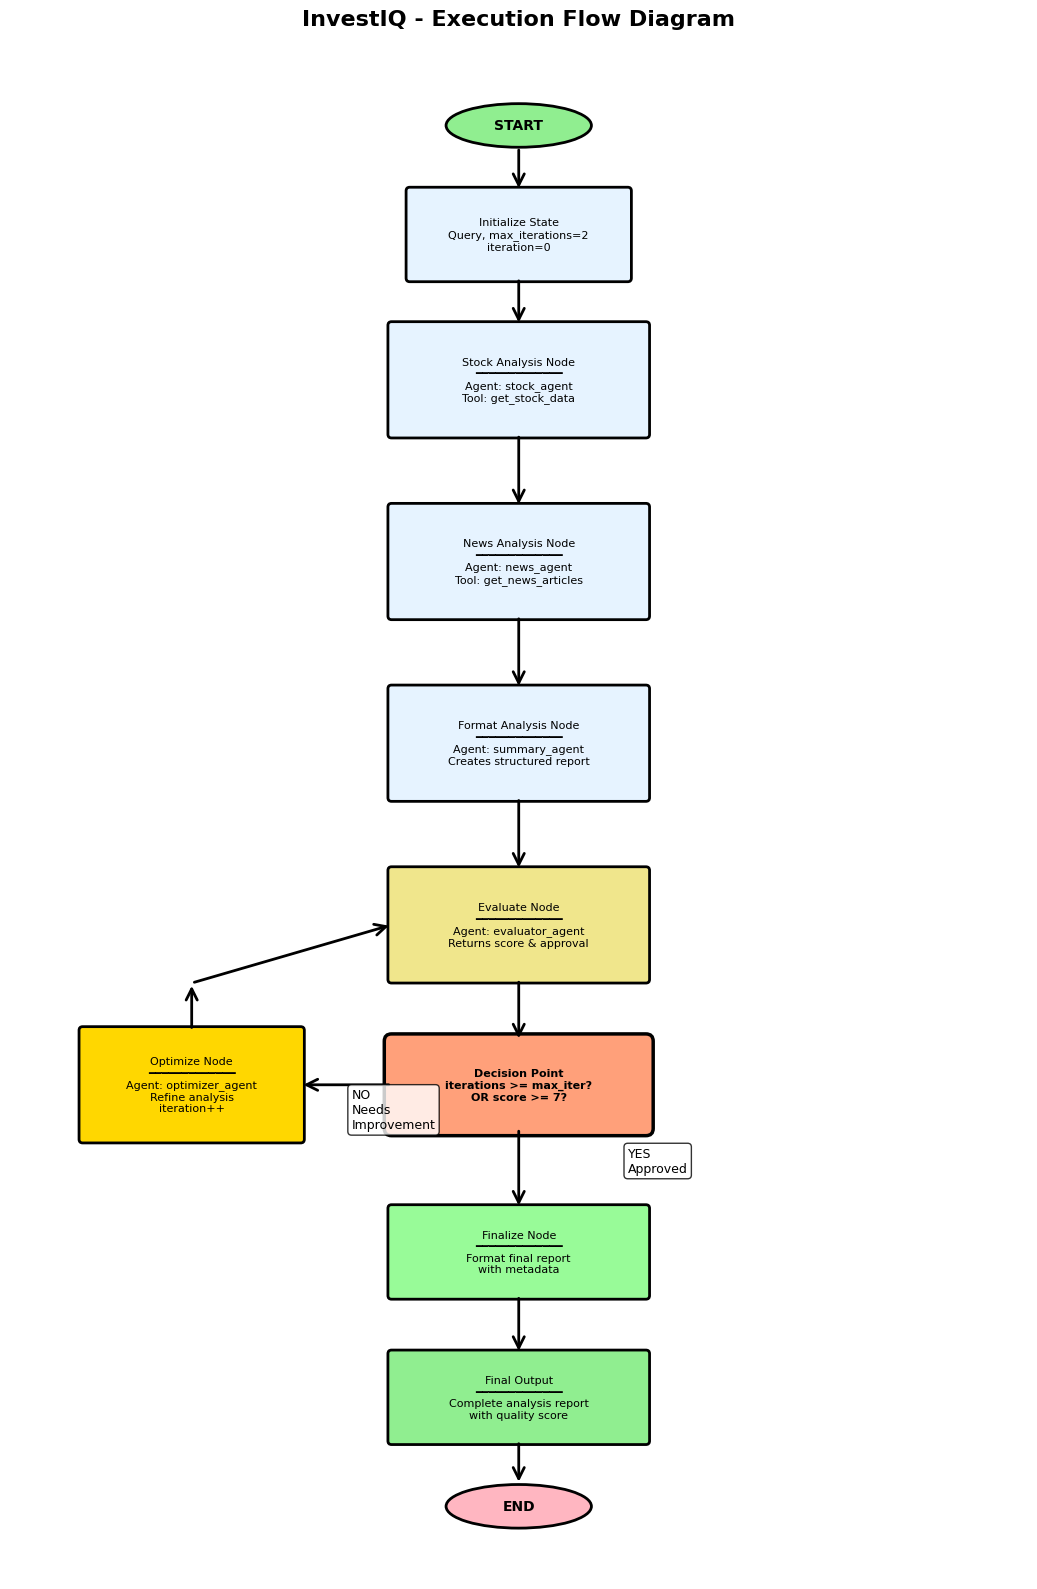

In [26]:
"""
InvestIQ Execution Flow Diagram for Jupyter Notebook
Install required packages: pip install matplotlib
"""

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

def create_investiq_flow_diagram():
    """Create InvestIQ execution flow diagram."""
    
    fig, ax = plt.subplots(figsize=(12, 16))
    
    # Define node positions (x, y) and sizes
    nodes = {
        'START': {'pos': (6, 15), 'size': (2, 0.6), 'shape': 'oval', 'color': '#90EE90'},
        'INIT': {'pos': (6, 13.5), 'size': (3, 1.2), 'shape': 'rect', 'color': '#E6F3FF',
                 'text': 'Initialize State\nQuery, max_iterations=2\niteration=0'},
        'SA': {'pos': (6, 11.5), 'size': (3.5, 1.5), 'shape': 'rect', 'color': '#E6F3FF',
               'text': 'Stock Analysis Node\n━━━━━━━━━━━━━\nAgent: stock_agent\nTool: get_stock_data'},
        'NA': {'pos': (6, 9), 'size': (3.5, 1.5), 'shape': 'rect', 'color': '#E6F3FF',
               'text': 'News Analysis Node\n━━━━━━━━━━━━━\nAgent: news_agent\nTool: get_news_articles'},
        'FA': {'pos': (6, 6.5), 'size': (3.5, 1.5), 'shape': 'rect', 'color': '#E6F3FF',
               'text': 'Format Analysis Node\n━━━━━━━━━━━━━\nAgent: summary_agent\nCreates structured report'},
        'EVAL': {'pos': (6, 4), 'size': (3.5, 1.5), 'shape': 'rect', 'color': '#F0E68C',
                 'text': 'Evaluate Node\n━━━━━━━━━━━━━\nAgent: evaluator_agent\nReturns score & approval'},
        'DECIDE': {'pos': (6, 1.8), 'size': (3.5, 1.2), 'shape': 'diamond', 'color': '#FFA07A',
                   'text': 'Decision Point\niterations >= max_iter?\nOR score >= 7?'},
        'OPT': {'pos': (1.5, 1.8), 'size': (3, 1.5), 'shape': 'rect', 'color': '#FFD700',
                'text': 'Optimize Node\n━━━━━━━━━━━━━\nAgent: optimizer_agent\nRefine analysis\niteration++'},
        'FIN': {'pos': (6, -0.5), 'size': (3.5, 1.2), 'shape': 'rect', 'color': '#98FB98',
                'text': 'Finalize Node\n━━━━━━━━━━━━━\nFormat final report\nwith metadata'},
        'OUTPUT': {'pos': (6, -2.5), 'size': (3.5, 1.2), 'shape': 'rect', 'color': '#90EE90',
                   'text': 'Final Output\n━━━━━━━━━━━━━\nComplete analysis report\nwith quality score'},
        'END': {'pos': (6, -4), 'size': (2, 0.6), 'shape': 'oval', 'color': '#FFB6C1'}
    }
    
    # Draw nodes
    for node_id, node_data in nodes.items():
        x, y = node_data['pos']
        w, h = node_data['size']
        color = node_data['color']
        text = node_data.get('text', node_id)
        
        if node_data['shape'] == 'oval':
            # Oval shape for START/END
            ellipse = mpatches.Ellipse((x, y), w, h, 
                                      facecolor=color, 
                                      edgecolor='black', 
                                      linewidth=2)
            ax.add_patch(ellipse)
        elif node_data['shape'] == 'diamond':
            # Diamond shape for decision
            diamond = mpatches.FancyBboxPatch(
                (x - w/2, y - h/2), w, h,
                boxstyle="round,pad=0.1",
                facecolor=color,
                edgecolor='black',
                linewidth=2.5
            )
            ax.add_patch(diamond)
        else:
            # Rectangle for regular nodes
            rect = FancyBboxPatch(
                (x - w/2, y - h/2), w, h,
                boxstyle="round,pad=0.05",
                facecolor=color,
                edgecolor='black',
                linewidth=2
            )
            ax.add_patch(rect)
        
        # Add text
        fontsize = 10 if node_id in ['START', 'END'] else 8
        weight = 'bold' if node_id in ['START', 'END', 'DECIDE'] else 'normal'
        ax.text(x, y, text, ha='center', va='center', 
                fontsize=fontsize, weight=weight)
    
    # Draw arrows
    arrows = [
        (6, 14.7, 6, 14.1),  # START to INIT
        (6, 12.9, 6, 12.25),  # INIT to SA
        (6, 10.75, 6, 9.75),  # SA to NA
        (6, 8.25, 6, 7.25),   # NA to FA
        (6, 5.75, 6, 4.75),   # FA to EVAL
        (6, 3.25, 6, 2.4),    # EVAL to DECIDE
        (6, 1.2, 6, 0.1),     # DECIDE to FIN (YES)
        (4.25, 1.8, 3, 1.8),  # DECIDE to OPT (NO)
        (1.5, 2.55, 1.5, 3.2),  # OPT curve up
        (1.5, 3.2, 4.25, 4),  # OPT to EVAL feedback
        (6, -1.1, 6, -1.9),   # FIN to OUTPUT
        (6, -3.1, 6, -3.7),   # OUTPUT to END
    ]
    
    for x1, y1, x2, y2 in arrows:
        arrow = FancyArrowPatch((x1, y1), (x2, y2),
                               arrowstyle='->', 
                               mutation_scale=20,
                               linewidth=2,
                               color='black')
        ax.add_patch(arrow)
    
    # Add edge labels
    ax.text(7.5, 0.6, 'YES\nApproved', fontsize=9, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.text(3.7, 1.2, 'NO\nNeeds\nImprovement', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Set limits and styling
    ax.set_xlim(-1, 13)
    ax.set_ylim(-5, 16)
    ax.axis('off')
    ax.set_aspect('equal')
    
    plt.title('InvestIQ - Execution Flow Diagram', 
              fontsize=16, weight='bold', pad=20)
    plt.tight_layout()
    
    return fig

# Run the diagram
if __name__ == "__main__":
    fig = create_investiq_flow_diagram()
    plt.show()

## End of the notebook